In [30]:
import seaborn as sns
import multiprocessing as mp
import pandas as pd
import tqdm
import time
import copy
import numpy as np
#import MySQLdb
import os
import pickle
import warnings
import matplotlib.pyplot as plt

import pickle
def save_variable(v,filename):
    f=open(filename,'wb')          #打开或创建名叫filename的文档。
    pickle.dump(v,f)               #在文件filename中写入v
    f.close()                      #关闭文件，释放内存。
    return filename

def load_variable(filename):
    try:
        f=open(filename,'rb')
        r=pickle.load(f)
        f.close()
        return r
    except EOFError:
        return ""

pickle_path='/Users/jason/JC/公告数据/'
Factor_total_dict = load_variable(pickle_path+'Factors')


In [31]:
#save_variable(signal_df,'/Users/jason/JC/公告数据/signal_df')

In [32]:
path = '/Users/jason/Desktop/公告类数据/'

In [4]:
exer_df = pd.read_excel(path+'股权激励.xlsx')
trade_vol = pd.read_excel(path+'交易量.xlsx')
ind_ret = pd.read_excel(path+'指数收益.xlsx')
buy_back_df = pd.read_excel(path+'回购.xlsx')
chg_df = pd.read_excel(path+'股东增持.xlsx')

In [5]:
twap_open = pd.read_excel(path+'TW开盘价.xlsx')
open_price = pd.read_excel(path+'开盘价.xlsx')
close_price = pd.read_excel(path+'收盘价.xlsx')
market_value = pd.read_excel(path+'市值.xlsx')
vwap = pd.read_excel(path+'VWAP.xlsx')

In [388]:
def treat_downloads(df):
    df = df.set_index('Unnamed: 0')
    df.columns = [int(i) for i in df.columns]
    df.index = [int(i) for i in df.index]
    return df

In [389]:
twap_ret = treat_downloads(twap_ret)

# 日期预处理

## 将日期全部改成int格式

In [199]:
twap_ret = load_variable(path+'theoretical_rtn_metric')
twap_open = load_variable(path+'TwapBegin60')
twap_close = load_variable(path+'TwapClose60')
def treat_downloads(df):
    df.columns = [int(i) for i in df.columns]
    return df

twap_ret = treat_downloads(twap_ret)
twap_open = treat_downloads(twap_open)
twap_close = treat_downloads(twap_close)

## 将其他dataframe的日期进行匹配

将触发的日期匹配到向未来最近的交易日，这样也能避免未来数据

In [201]:
def datetime_to_int(x):
    try:
        if type(x) == type(1):
            return int(x)
        else:
            return int(x.strftime('%Y%m%d'))
    except:
        return np.nan
#chg_df.FIRST_PUBLISH_DATE.apply(datetime_to_str)
def str_to_int(x):
    return int(x)

def get_whole_year(start,end):
    import datetime
    begin = datetime.date(start, 1, 1)
    now = begin
    end = datetime.date(end, 12, 31)
    delta = datetime.timedelta(days=1)
    days = []
    while now <= end:
        date=now.year*10000+now.month*100+now.day
        days.append(date)
        now += delta
    return days

def match_revised(dates_equ,dates_twop):
    import datetime
    dates_mod=[]
    calendar=get_whole_year(2000,2025)
    for i in dates_equ:
        if np.isnan(i):
            dates_mod.append(i)
        else:
            date_temp=i
            date_posi=calendar.index(date_temp)
            if i>=dates_twop[-1]:
                dates_mod.append(dates_twop[-1])
                continue
            while(date_temp not in dates_twop):
                date_posi=date_posi+1
                date_temp=calendar[date_posi]
            date_mat=date_temp
            dates_mod.append(date_mat)
    return dates_mod


exer_df_date = copy.deepcopy(exer_df)
exer_df_date['PUBLISH_DATE'] = match_revised(exer_df.PUBLISH_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])
exer_df_date['INI_DATE'] = match_revised(exer_df.INI_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])
exer_df_date['SHC_DATE'] = match_revised(exer_df.SHC_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])

buy_back_date = copy.deepcopy(buy_back_df)
buy_back_date['PUBLISH_DATE'] = match_revised(buy_back_df.PUBLISH_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])
buy_back_date['PRE_PUB_DATE'] = match_revised(buy_back_df.PRE_PUB_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])

chg_df_date = copy.deepcopy(chg_df)
chg_df_date['FIRST_PUBLISH_DATE'] = match_revised(chg_df.FIRST_PUBLISH_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])
chg_df_date['BEGIN_DATE'] = match_revised(chg_df.BEGIN_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])
chg_df_date['END_DATE'] = match_revised(chg_df.END_DATE.
                                             apply(datetime_to_int),[int(i) for i in twap_ret.columns])

In [202]:
def datetime_to_int(x):
    try:
        if type(x) == type(1):
            return x
        else:
            return int(x.strftime('%Y%m%d'))
    except:
        return np.nan

# 持股变化（chg）

## 描述性统计

In [204]:
pd.Series([int(i/10000) for i in exer_df_date.PUBLISH_DATE]).value_counts()

2021    829
2022    466
2020    448
2018    408
2019    331
dtype: int64

In [206]:
pd.Series([int(i/10000) for i in chg_df_date.BEGIN_DATE]).value_counts()

2020    6860
2021    6234
2019    5623
2018    4587
2022    3964
2017    1661
2016      16
2012       1
2015       1
dtype: int64

In [207]:
#公司未来97%都是增持，其他的基本90%以上都是减持，国家政策是唯一对半分的
denom = chg_df_date.groupby(['REASON_SMP']).count().TICKER_SYMBOL
pct_df = pd.DataFrame((chg_df_date.groupby(['REASON_SMP','CHANGE_DIR']).count().TICKER_SYMBOL/denom).round(2))
count = pd.DataFrame((chg_df_date.groupby(['REASON_SMP','CHANGE_DIR']).count().TICKER_SYMBOL).round(2))['TICKER_SYMBOL']
pct_df['count'] = count
pct_df.columns = ['pct','count']
pct_df

pct  count
REASON_SMP CHANGE_DIR             
不利因素       1           0.05     16
           2           0.95    321
个人其他       1           0.00      6
           2           1.00   5205
偿还债务       1           0.00      1
           2           1.00   1078
公司未来       1           0.97   3061
           2           0.03     96
公司经营       1           0.04     45
           2           0.96   1144
公司资金       1           0.02     47
           2           0.98   2805
其他         1           0.08     63
           2           0.92    690
国家政策       1           0.54     31
           2           0.46     26
基金运作       1           0.02      6
           2           0.98    362
自身需求       2           1.00  13944

In [208]:
#345主要看中公司前景，12主要是自身需求和公司资金需求
denom = chg_df_date.groupby(['SH_NAME_TYPE']).count().TICKER_SYMBOL
pct_df = pd.DataFrame((chg_df_date.groupby(['SH_NAME_TYPE','REASON_SMP']).count().TICKER_SYMBOL/denom).round(2))
count = pd.DataFrame((chg_df_date.groupby(['SH_NAME_TYPE','REASON_SMP']).count().TICKER_SYMBOL).round(2))['TICKER_SYMBOL']
pct_df['count'] = count
pct_df.columns = ['pct','count']
pct_df

pct  count
SH_NAME_TYPE REASON_SMP             
1            不利因素        0.01    104
             个人其他        0.22   2612
             偿还债务        0.02    261
             公司未来        0.03    405
             公司经营        0.09   1099
             公司资金        0.18   2096
             其他          0.04    459
             国家政策        0.00     19
             基金运作        0.03    355
             自身需求        0.37   4395
2            不利因素        0.00     56
             个人其他        0.16   2201
             偿还债务        0.04    570
             公司未来        0.11   1493
             公司经营        0.00     22
             公司资金        0.03    417
             其他          0.01    107
             国家政策        0.00     24
             基金运作        0.00      6
             自身需求        0.64   8639
3            不利因素        0.07     98
             个人其他        0.11    159
             偿还债务        0.06     92
             公司未来        0.38    556
             公司经营        0.03     38
             公司资金        0.13    193
             其他          0.06     89
             国家政策        0.00      6
             基金运作        0.00      2
             自身需求        0.15    215
4            不利因素        0.04     79
             个人其他        0.12    237
             偿还债务        0.08    156
             公司未来        0.26    494
             公司经营        0.01     28
             公司资金        0.07    140
             其他          0.04     72
             国家政策        0.00      5
             基金运作        0.00      1
             自身需求        0.36    695
5            个人其他        0.01      2
             公司未来        0.83    209
             公司经营        0.01      2
             公司资金        0.02      6
             其他          0.10     26
             国家政策        0.01      3
             基金运作        0.02      4

In [707]:
#增持主要是因为公司未来（93%），减持主要是自身需求以及自身其他（74%）
denom = chg_df_date.groupby(['CHANGE_DIR']).count().TICKER_SYMBOL
pct_df = pd.DataFrame((chg_df_date.groupby(['CHANGE_DIR','REASON_SMP']).count().TICKER_SYMBOL/denom).round(2))
count = pd.DataFrame((chg_df_date.groupby(['CHANGE_DIR','REASON_SMP']).count().TICKER_SYMBOL).round(2))['TICKER_SYMBOL']
pct_df['count'] = count
pct_df.columns = ['pct','count']
pct_draw_df = pct_df.pct.unstack()

In [711]:
pct_draw_df.index = ['Increase','Reduce']
pct_draw_df.columns = ['Disadvantage','Other personal needs','Repay debts',"Company future",'Company operation','Company funds',
                      'Others','National policy','Fund operation','Personal need']

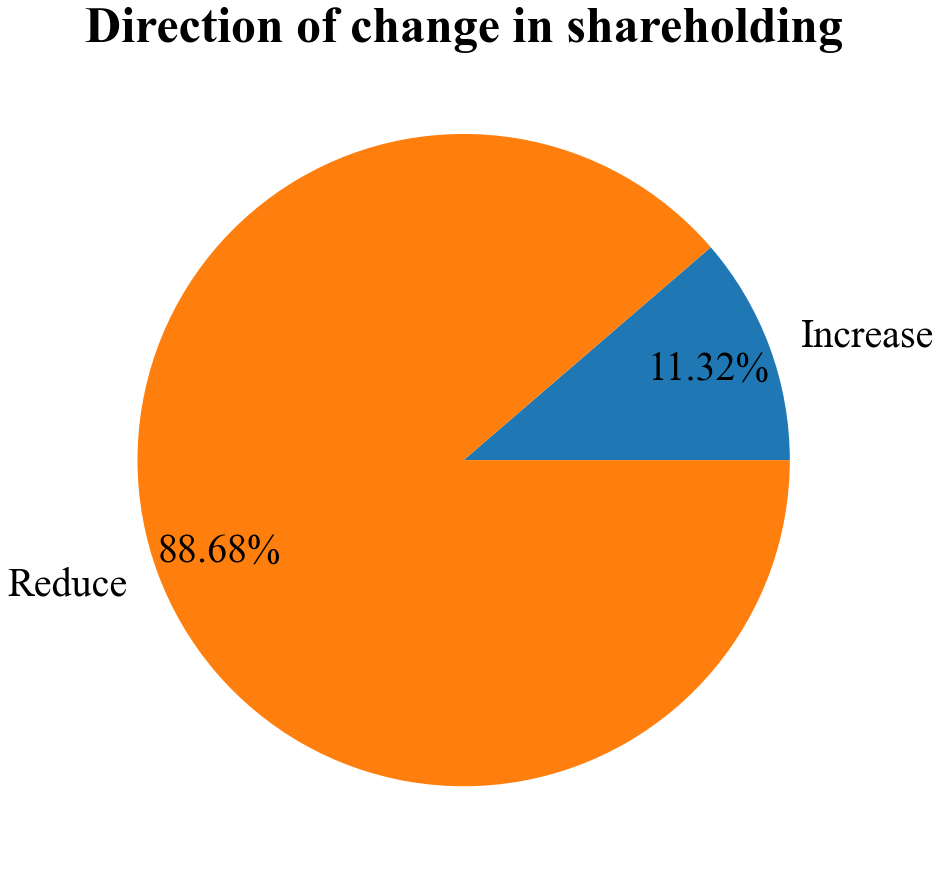

In [1244]:
denom = chg_df_date.groupby(['CHANGE_DIR']).count().TICKER_SYMBOL
plt.figure(figsize=(15,15))
plt.pie(denom,labels=['Increase','Reduce'],autopct='%.2f%%',pctdistance=0.8,
        textprops={'fontsize': 40, 'color': 'black'})
#plt.legend(pct_draw_df.columns,fontsize=5,loc='center right')
plt.title('Direction of change in shareholding',fontsize=50,pad=10,fontproperties='Times New Roman',fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Change direction 1 PIE.jpg')

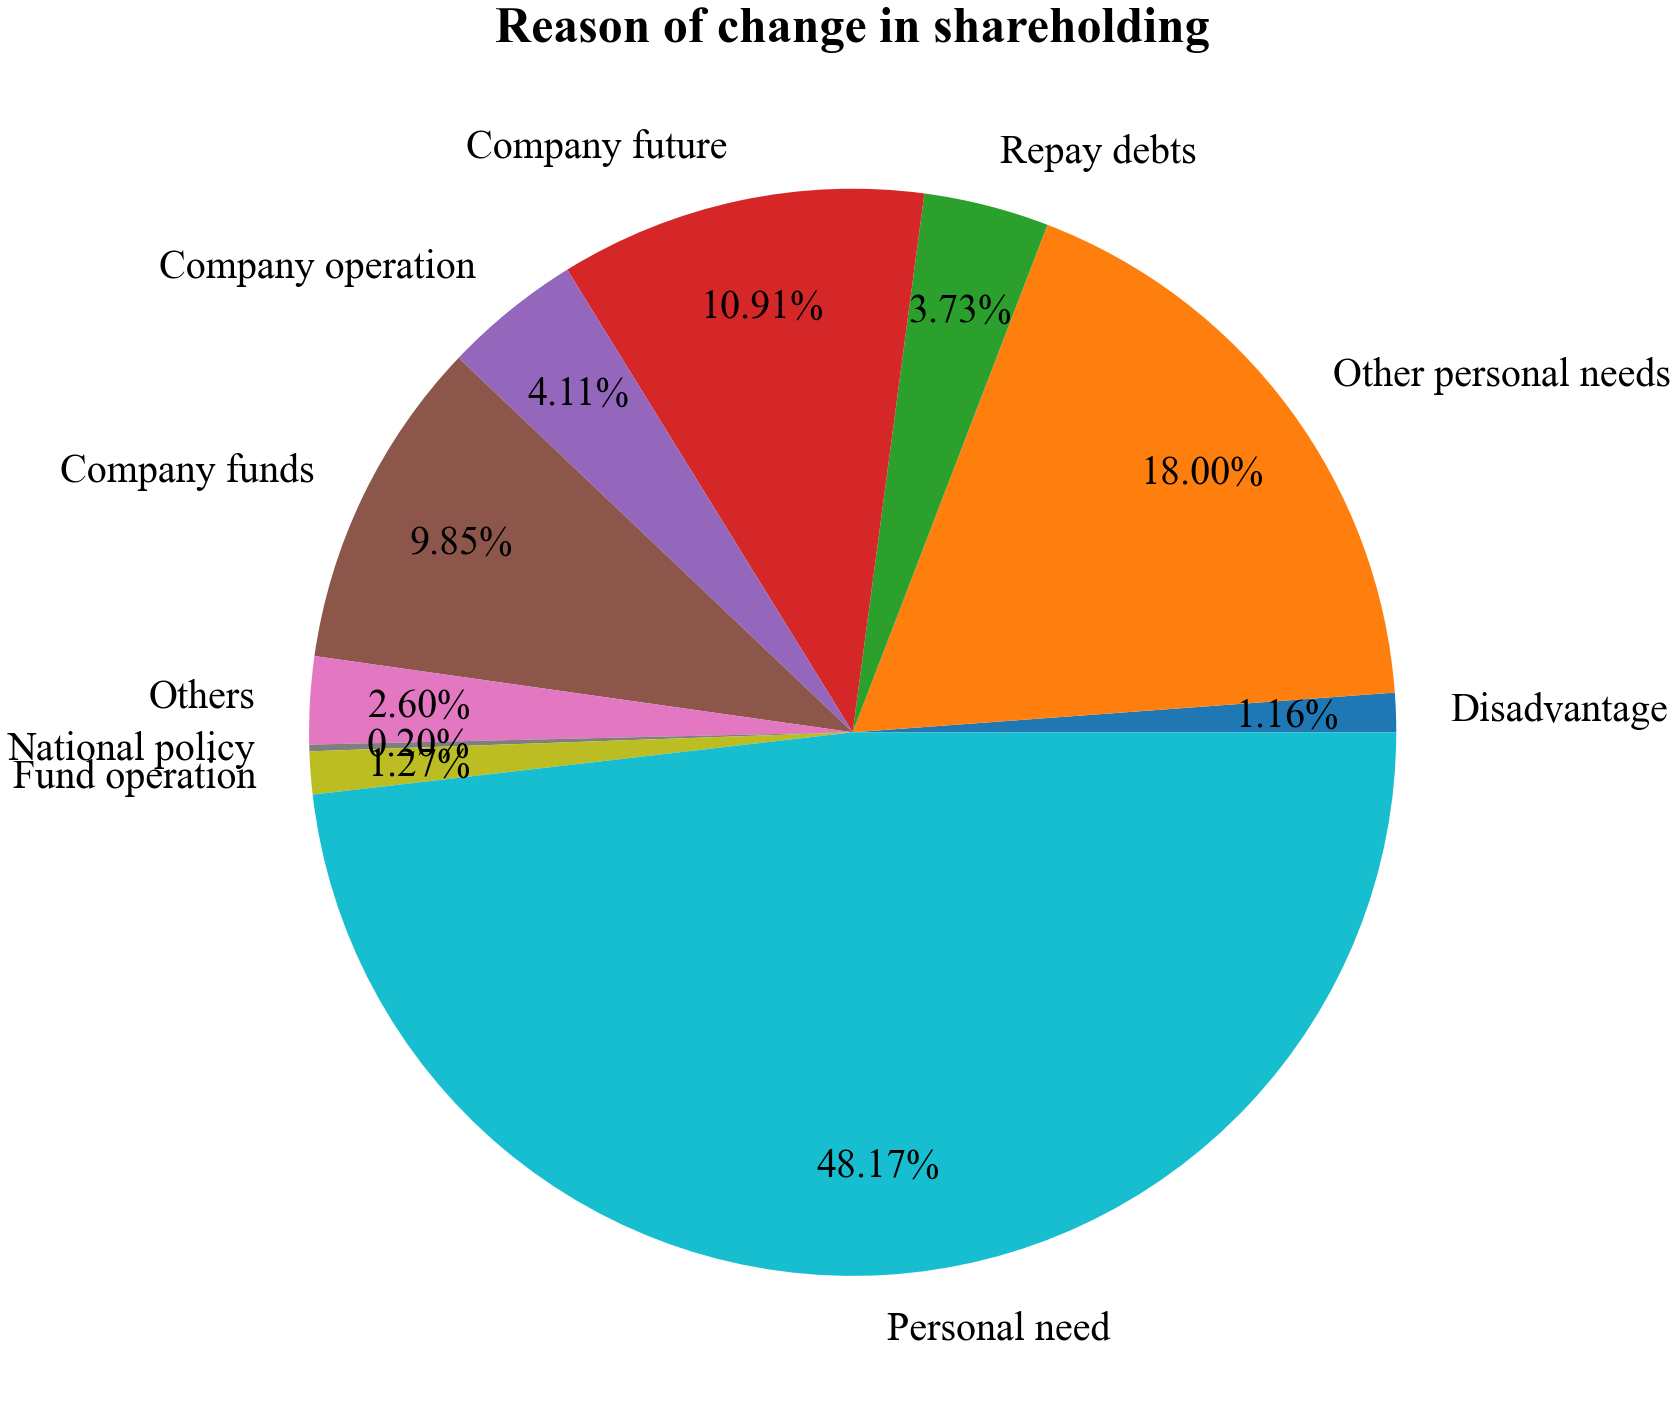

In [1242]:
denom = chg_df_date.groupby(['REASON_SMP']).count().TICKER_SYMBOL

plt.figure(figsize=(25,25))
plt.pie(denom,labels=pct_draw_df.columns,autopct='%.2f%%',pctdistance=0.8,
        textprops={'fontsize': 40, 'color': 'black'})
#plt.legend(pct_draw_df.columns,fontsize=5,loc='center right')
plt.title('Reason of change in shareholding',fontsize=50,pad=10,fontproperties='Times New Roman',fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Change direction REASON_SMP PIE.jpg')

In [ ]:
denom = chg_df_date.groupby(['REASON_SMP']).count().TICKER_SYMBOL

plt.figure(figsize=(15,15))
plt.pie(denom,labels=pct_draw_df.columns,autopct='%.2f%%',pctdistance=0.8,
        textprops={'fontsize': 20, 'color': 'black'})
#plt.legend(pct_draw_df.columns,fontsize=5,loc='center right')
plt.title('Reason of change in shareholding',fontsize=25,pad=10,fontproperties='Times New Roman',fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Change direction REASON_SMP PIE.jpg')

In [1230]:
chg_df_date.groupby(['SH_NAME_TYPE']).count().TICKER_SYMBOL


SH_NAME_TYPE
1    11805
2    13535
3     1448
4     1907
5      252
Name: TICKER_SYMBOL, dtype: int64

In [1188]:
def draw_stack(pct_draw_df,name,name2,size=9):
    pct_draw_df = (pct_draw_df.fillna(0).T/pct_draw_df.fillna(0).sum(axis=1)).T
    Ind = pct_draw_df.fillna(0).T.sum(axis=1).sort_values(ascending = False).index
    s = pct_draw_df[Ind].fillna(0).cumsum(axis=1)

    plt.figure(figsize=(size,8),dpi=200)
    plt.xlim(-1.7,2)
    for i in range(0,len(Ind)):
        plt.bar([-1,0],s.iloc[:,len(Ind)-i-1])
    a = list(Ind)
    a.reverse()
    plt.legend(a,fontsize=16)

    plt.xticks([-1,0],s.index,fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(name,size=25)
    plt.title(name2,fontsize=25,pad=20,fontproperties='Times New Roman',fontweight=600)
    
    return plt

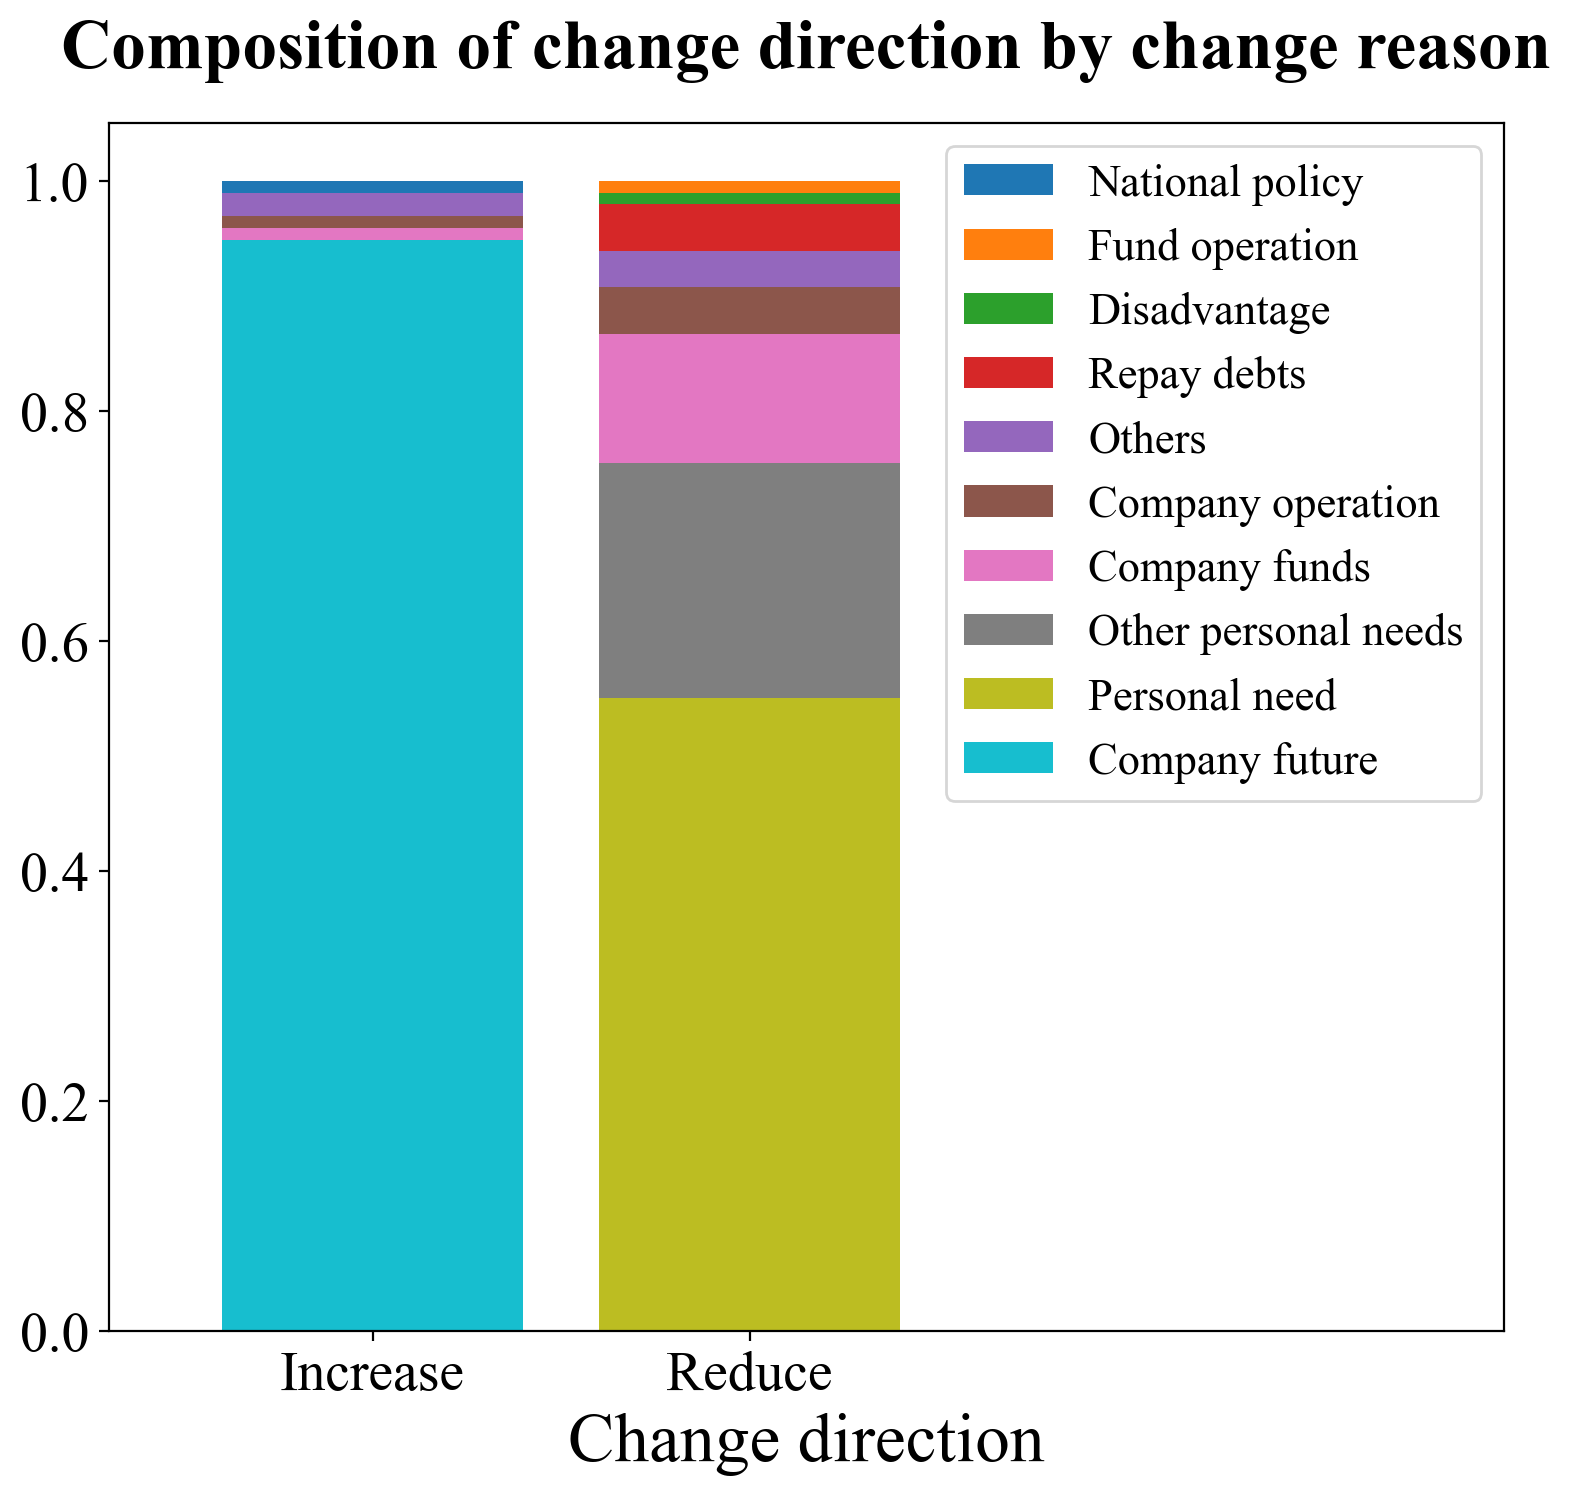

In [1189]:
a = draw_stack(pct_draw_df,name='Change direction',name2 = 'Composition of change direction by change reason')
a.savefig('/Users/jason/JC/公告数据/Figures/Change direction pie.jpg')

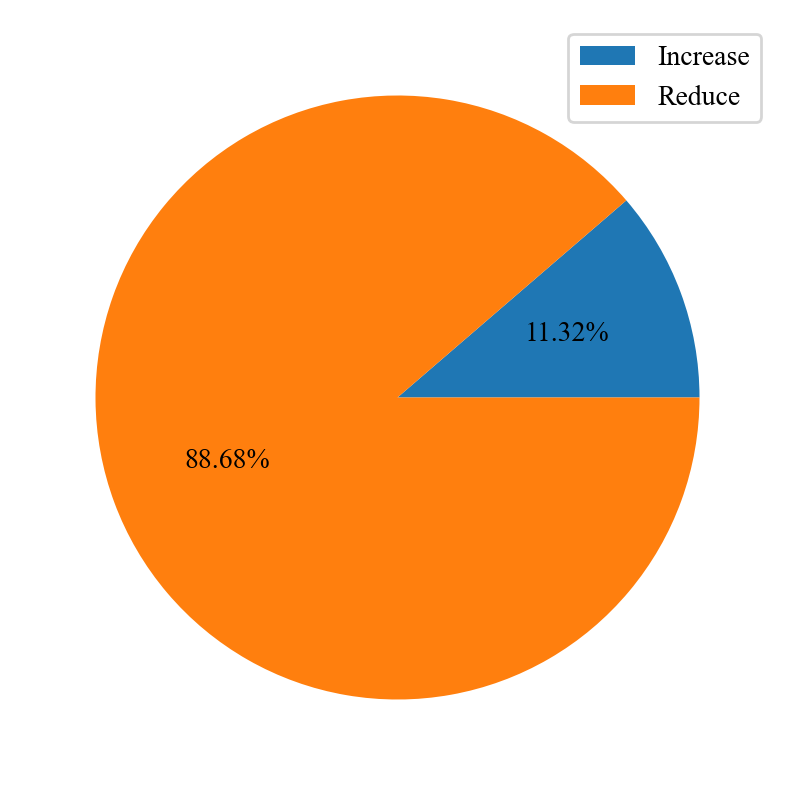

In [948]:
a = draw_pie(denom)


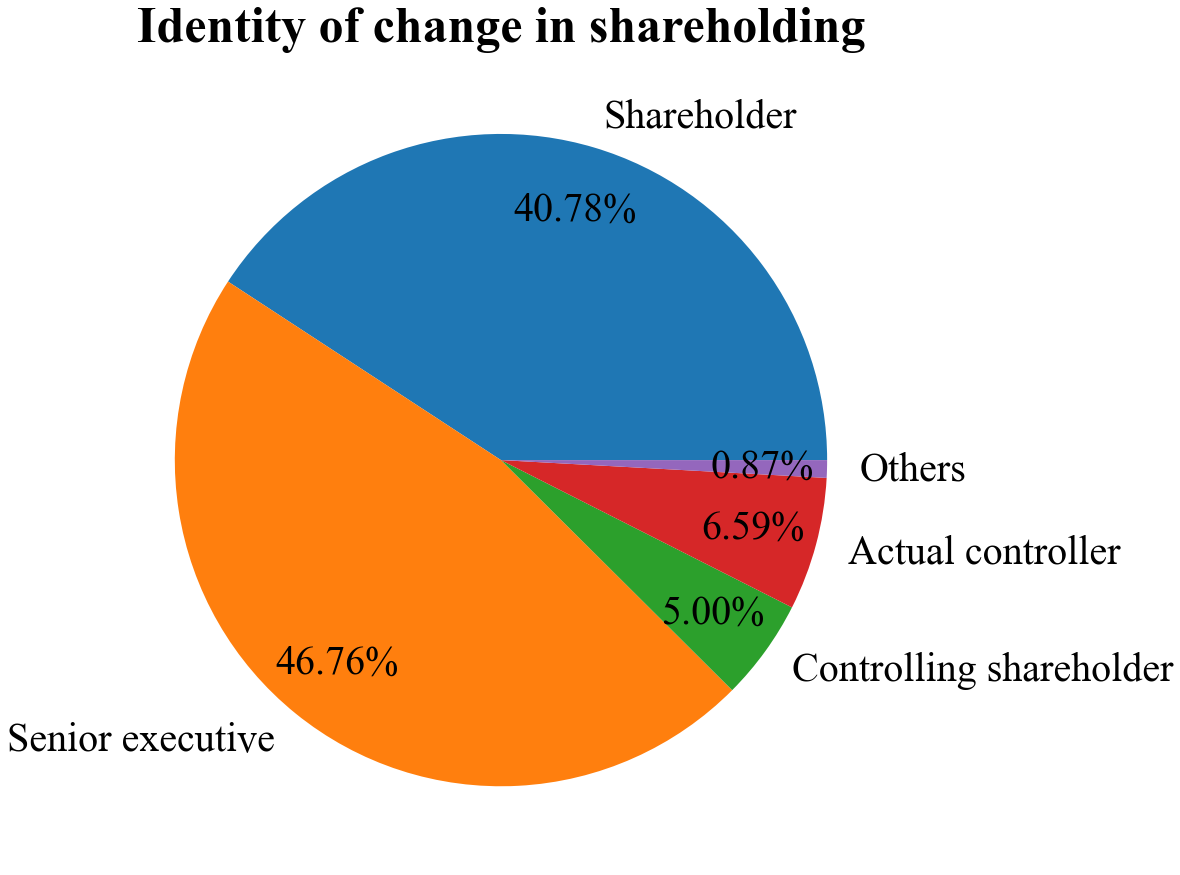

In [1237]:
denom = chg_df_date.groupby(['SH_NAME_TYPE']).count().TICKER_SYMBOL

plt.figure(figsize=(15,15))
plt.pie(denom,labels=['Shareholder','Senior executive',
                         'Controlling shareholder','Actual controller','Others'],autopct='%.2f%%',pctdistance=0.8,
        textprops={'fontsize': 40, 'color': 'black'})
#plt.legend(pct_draw_df.columns,fontsize=5,loc='center right')
plt.title('Identity of change in shareholding',fontsize=50,pad=10,fontproperties='Times New Roman',fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Change direction Identity PIE.jpg')

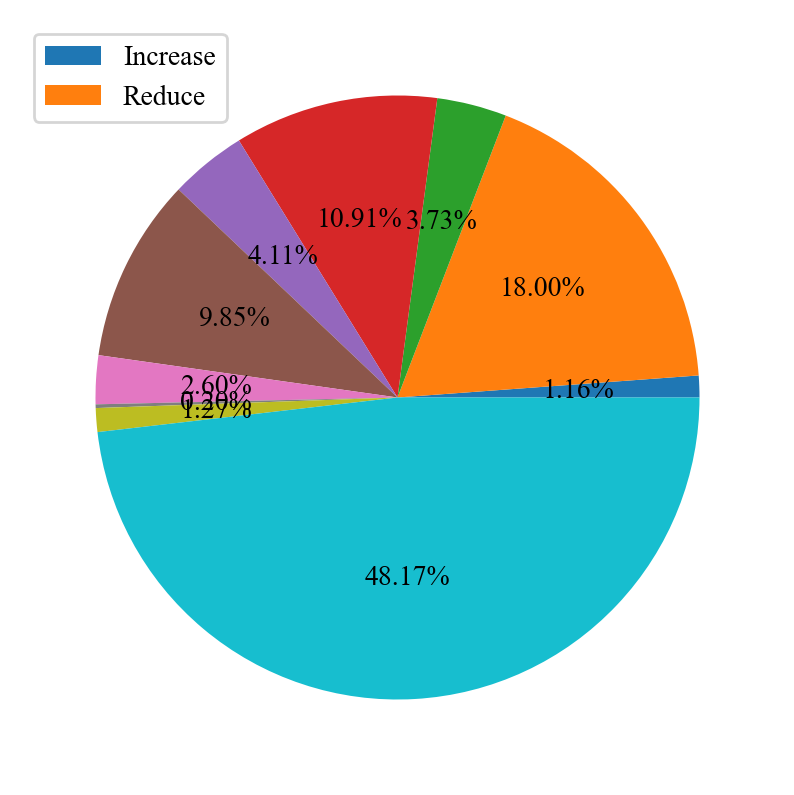

In [949]:
denom = chg_df_date.groupby(['REASON_SMP']).count().TICKER_SYMBOL
a = draw_pie(denom)
a.savefig('/Users/jason/JC/公告数据/Figures/Change reason PIE.jpg')

In [891]:
#12类主要减持，其他类别也主要是减持，但是也有一部分增持
denom = chg_df_date.groupby(['CHANGE_DIR']).count().TICKER_SYMBOL
pct_df = pd.DataFrame((chg_df_date.groupby(['CHANGE_DIR','SH_NAME_TYPE']).count().TICKER_SYMBOL/denom).round(2))
count = pd.DataFrame((chg_df_date.groupby(['CHANGE_DIR','SH_NAME_TYPE']).count().TICKER_SYMBOL).round(2))['TICKER_SYMBOL']
pct_df['count'] = count
pct_df.columns = ['pct','count']
share_type_df = pct_df['pct'].unstack().fillna(0)

In [892]:
share_type_df.index = ['Increase','Reduce']
share_type_df.columns = ['Shareholder','Senior executive',
                         'Controlling shareholder','Actual controller','Others']

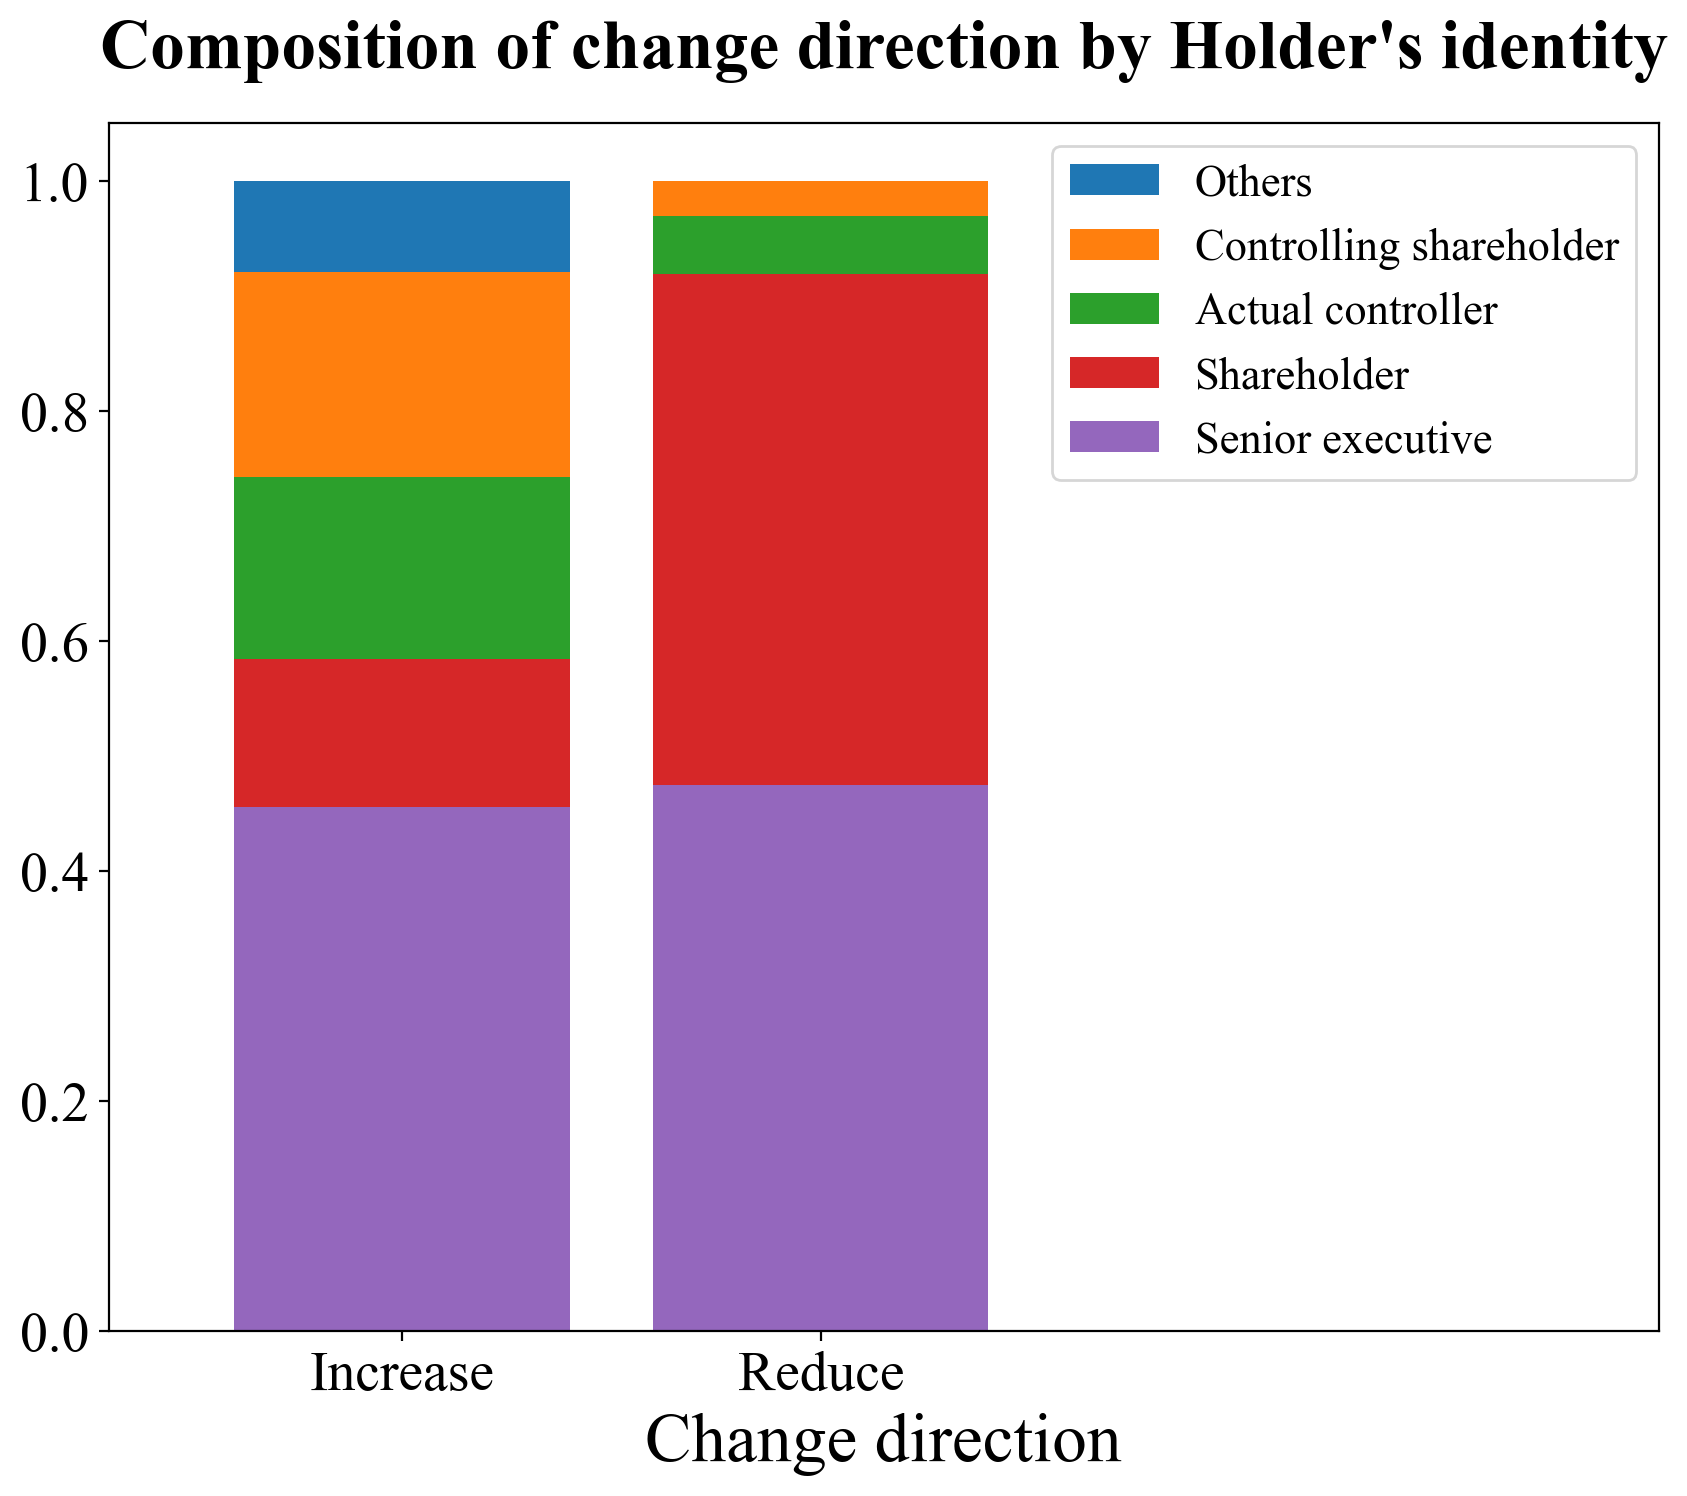

In [1190]:
a = draw_stack(share_type_df,name="Change direction",name2 = "Composition of change direction by Holder's identity",size=10)
a.savefig("/Users/jason/JC/公告数据/Figures/Holder's identity pie.jpg")

## 策略

In [212]:
chg_df_part = chg_df_date[(chg_df_date.REASON_SMP=='公司未来') &
       (chg_df_date.CHANGE_DIR==1) &
      ((chg_df_date.SH_NAME_TYPE==3)| 
      (chg_df_date.SH_NAME_TYPE==4)|
       (chg_df_date.SH_NAME_TYPE==5))]

In [213]:
chg_df_part.count()

Unnamed: 0            1250
TICKER_SYMBOL         1250
FIRST_PUBLISH_DATE    1250
BEGIN_DATE            1250
END_DATE              1250
PROJ_CHG              1250
SH_NAME_TYPE          1250
CHANGE_DIR            1250
SHARE_HOLD_BF         1250
SHARE_CHANGES_UPL     1250
RATIO_UPL             1250
REASON_SMP            1250
dtype: int64

## 分事件测试

In [1282]:
def get_ret_frame(df,datetype='FIRST_PUBLISH_DATE'):
    df = df.copy().dropna(subset=[datetype])
    df = df[(df[datetype]>=20180101) & (df[datetype]<20220701)]
    period = 20
    period_last = 20
    df[datetype] = [int(i) for i in df[datetype]]
    date_list = [int(i) for i in list(twap_ret.columns)]
    max_date = date_list[-period]
    df_part = df[df[datetype]<=max_date]
    print(df_part.shape)

    Ret_dict = {}
    for i in df_part.index:
        date = (df_part.loc[i][datetype])
        ticker = df_part.loc[i]['TICKER_SYMBOL']
        #print(ticker)
        if int(ticker) not in twap_ret.index:
            continue
        start_ind = date_list.index(date)
        Ret = twap_ret.loc[int(ticker)][start_ind-period_last:start_ind+period+1]
        Ret_dict[int(ticker)] = Ret

    for j in Ret_dict:
        ini_lst = [i for i in Ret_dict[j]]
        if len(ini_lst)!=41:
            ini_lst = ini_lst + [np.nan]*(41-len(ini_lst))
        Ret_dict[j] = ini_lst
        
    Ret_df = pd.DataFrame({j:[i for i in Ret_dict[j]] for j in Ret_dict})
    
    date_df = pd.DataFrame(np.arange(0,len(twap_ret.T)),index = [int(i) for i in list(twap_ret.columns)])
    Ret_all_df = pd.DataFrame(Ret_dict).merge(date_df,left_index=True,right_index=True,how='outer')   
    
    return Ret_df,Ret_all_df,df_part.shape

def draw_ret_frame(Ret_df,Ret_all_df):
    m = Ret_df.mean(axis=1)
    std = Ret_df.std(axis=1)*0.1
    Ret_cumsum = m.cumsum()
    Ret_cumsum1 = (m+std).cumsum()
    Ret_cumsum2 = (m-std).cumsum()

    plt.plot(Ret_cumsum - Ret_cumsum.iloc[period_last])
    a = Ret_cumsum2- Ret_cumsum2.iloc[period_last]
    b = Ret_cumsum1- Ret_cumsum1.iloc[period_last]
    ab = list(a)+list(b)
    plt.fill_between(Ret_cumsum.index,a,
                     b,alpha=0.2)
    plt.vlines(20,min(ab),max(ab))
    plt.show()

    plt.plot(list(Ret_all_df.count(axis=1)))
    plt.show()  

def draw_total(dfs = [exer_df_date,exer_df_part],date = 'SHC_DATE',name = 'shareholder meeting date of equity incentive'):

    a1, b1, s1 = get_ret_frame(dfs[0],datetype=date)
    a2, b2, s2 = get_ret_frame(dfs[1],datetype=date)
    
    plt.figure(figsize=(15,8),dpi=200)
    plt.rcParams['font.family'] = 'Times New Roman' #设置字体

    period_last = 20
    m = a1.mean(axis=1)
    std = a1.std(axis=1)*0.1
    Ret_cumsum = m.cumsum()
    Ret_cumsum1 = (m+std).cumsum()
    Ret_cumsum2 = (m-std).cumsum()
    plt.plot(Ret_cumsum - Ret_cumsum.iloc[period_last],color = 'blue')
    a = Ret_cumsum2- Ret_cumsum2.iloc[period_last]
    b = Ret_cumsum1- Ret_cumsum1.iloc[period_last]
    ab = list(a)+list(b)
    plt.fill_between(Ret_cumsum.index,a,
                     b,alpha=0.2,color = 'blue')
    plt.vlines(20,min(ab),max(ab),color = 'black')
    plt.hlines(0,0,40,color = 'black')

    m = a2.mean(axis=1)
    std = a2.std(axis=1)*0.1
    Ret_cumsum = m.cumsum()
    Ret_cumsum1 = (m+std).cumsum()
    Ret_cumsum2 = (m-std).cumsum()
    plt.plot(Ret_cumsum - Ret_cumsum.iloc[period_last],color = 'red')
    a = Ret_cumsum2- Ret_cumsum2.iloc[period_last]
    b = Ret_cumsum1- Ret_cumsum1.iloc[period_last]
    ab = list(a)+list(b)
    plt.fill_between(Ret_cumsum.index,a,
                     b,alpha=0.2,color = 'red')

    plt.legend(['Original ({} signals)'.format(s1[0]),'Filtered ({} signals)'.format(s2[0])],fontsize=20)
    l = list(np.arange(-20,21))
    l[20] = 'T'
    plt.yticks(fontproperties='Times New Roman', size=15)
    plt.xticks(np.arange(0,41),l,fontproperties='Times New Roman', size=15)
    plt.xlabel('Days before and after announcement', size=25)
    plt.ylabel('Cumulative return', size=25)
    plt.title('Return before and after {} (-+std)'.format(name),fontsize=25,pad=20,fontweight=600)
    #plt.show() 
    
    return plt

(26735, 12)
(1042, 12)


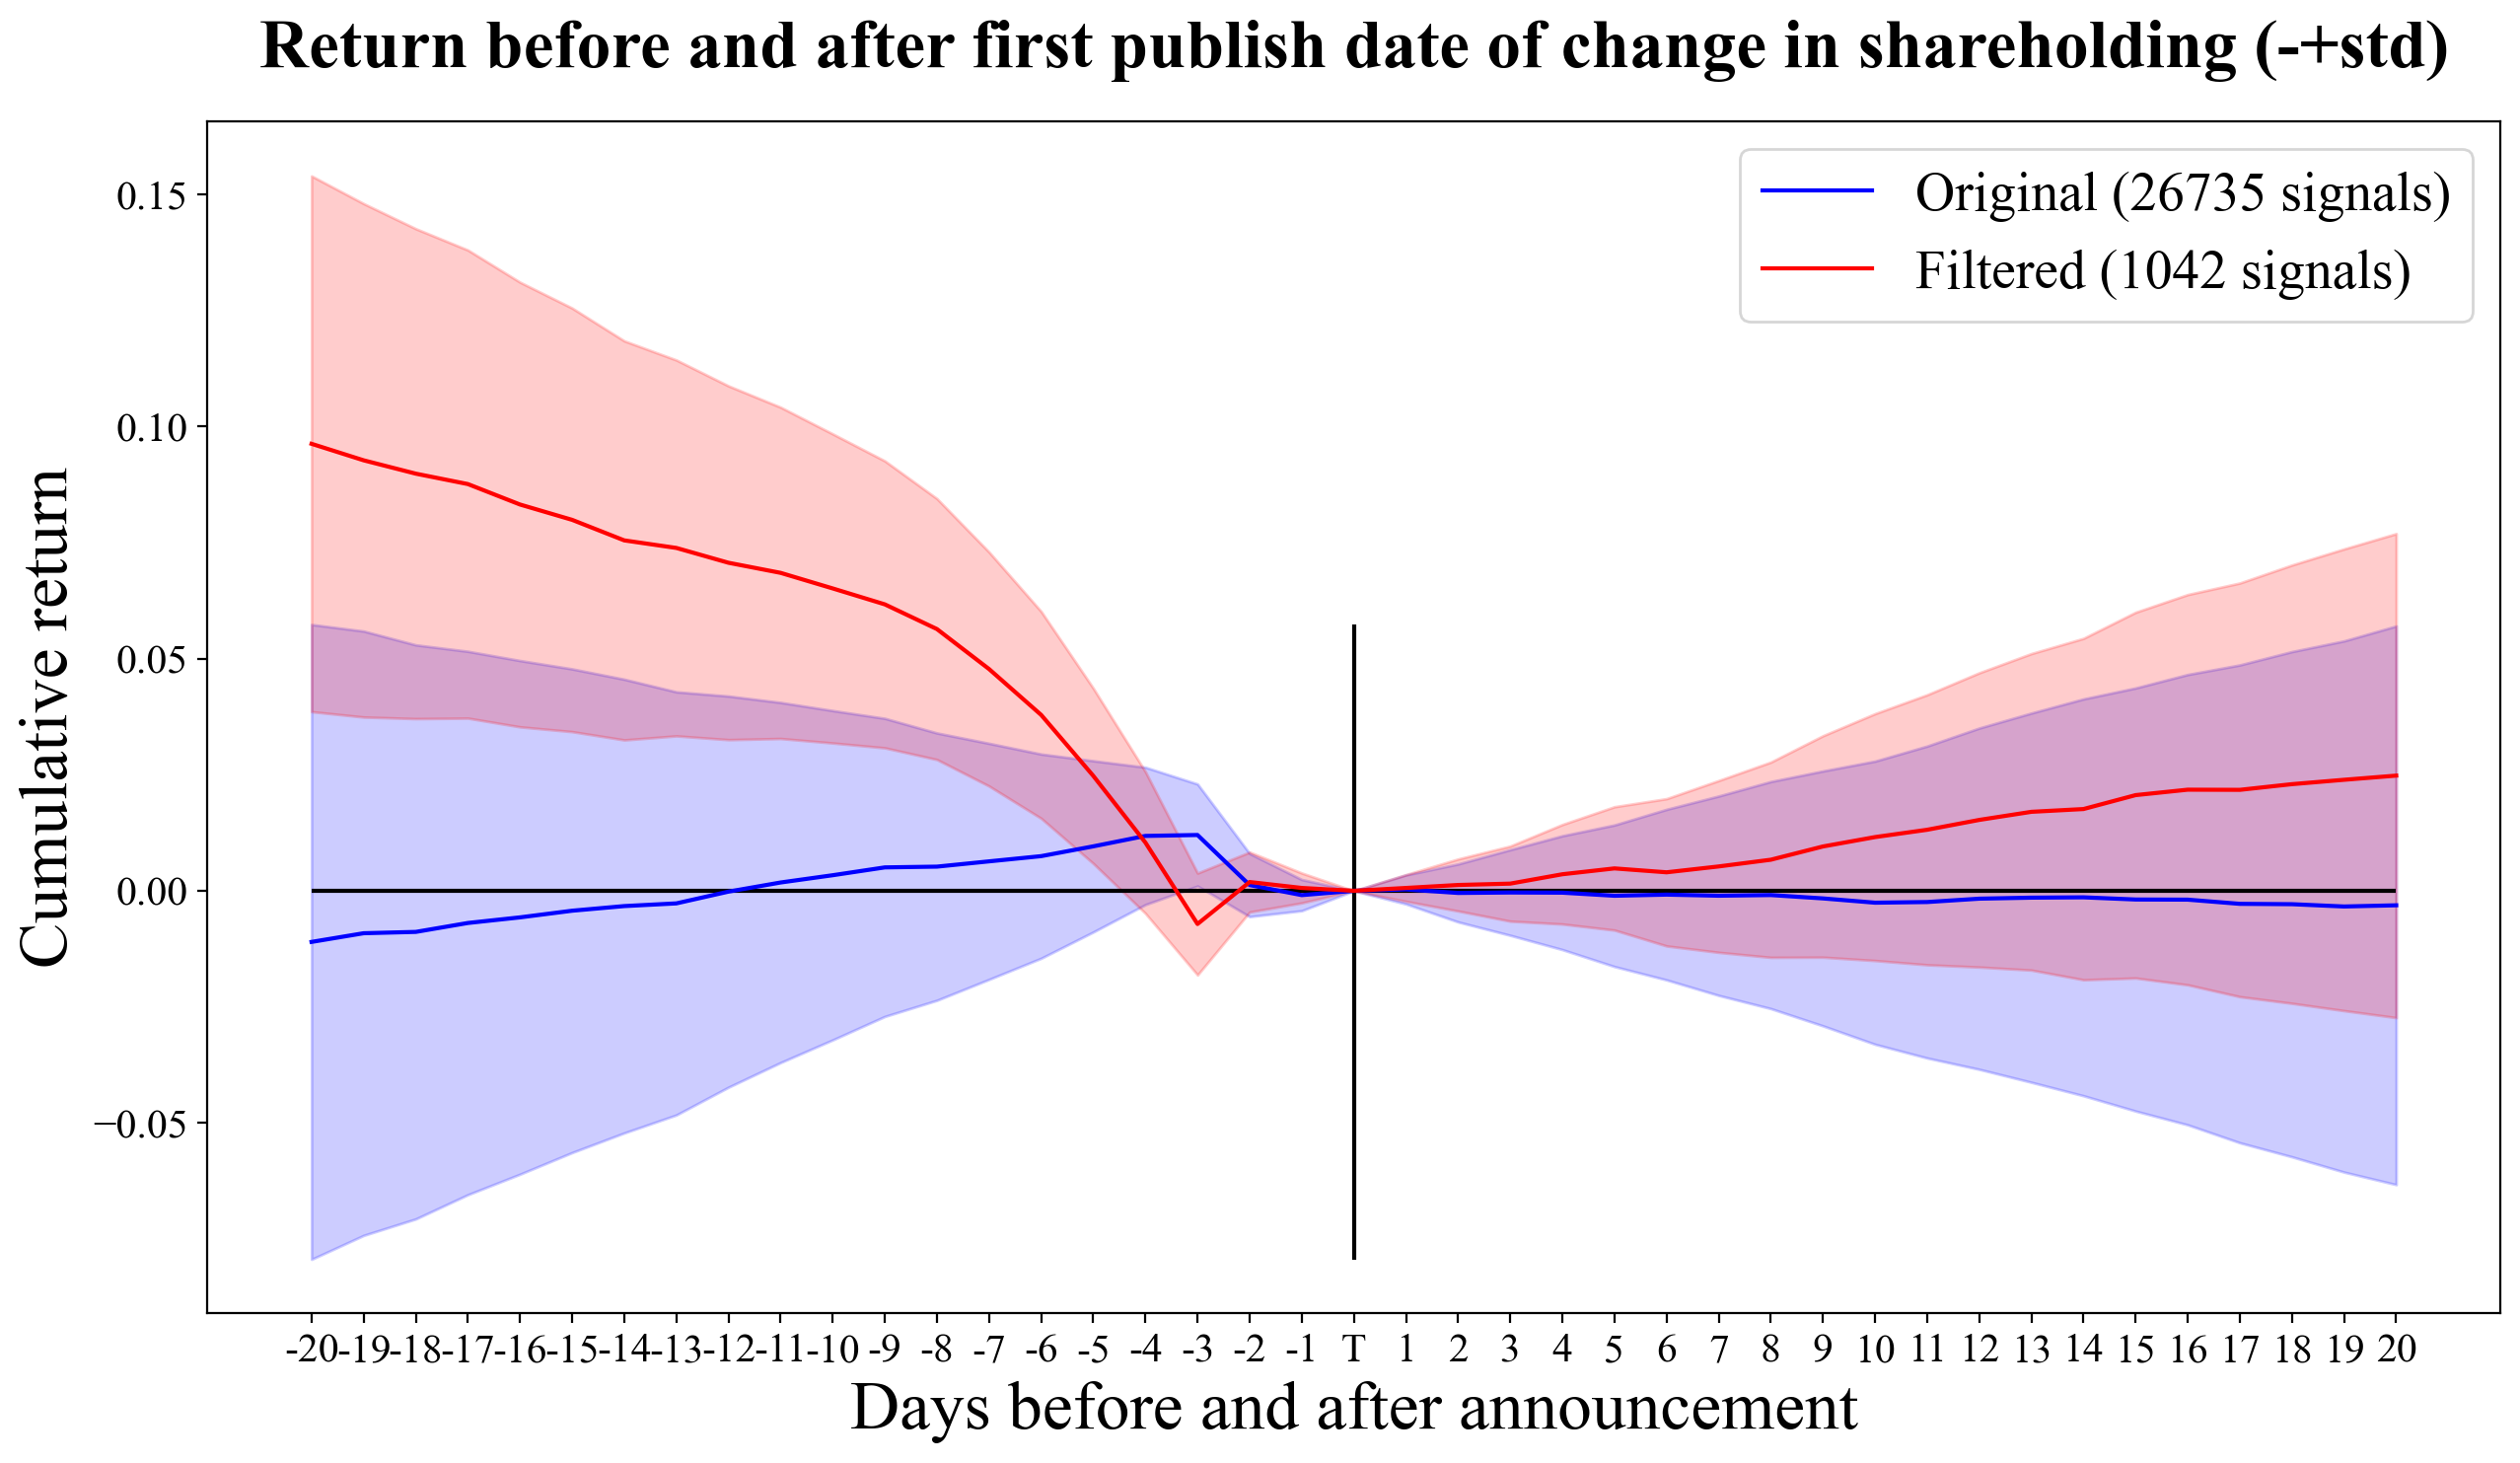

In [1272]:
a = draw_total(dfs = [chg_df_date,chg_df_part],date = 'FIRST_PUBLISH_DATE',name = 'first publish date of change in shareholding')
a.savefig('/Users/jason/JC/公告数据/Figures/first publish date of change in shareholding.jpg')


In [649]:
datetype = 'BEGIN_DATE'
df = chg_df_date.copy().dropna(subset=[datetype])
period = 20
period_last = 20
df[datetype] = [int(i) for i in df[datetype]]
date_list = [int(i) for i in list(twap_ret.columns)]
max_date = date_list[-period]
df_part = df[df[datetype]<=max_date]
print(df_part.shape)

Ret_dict = {}
for i in df_part.index:
    date = (df_part.loc[i][datetype])
    ticker = df_part.loc[i]['TICKER_SYMBOL']
    #print(ticker)
    if int(ticker) not in twap_ret.index:
        continue
    start_ind = date_list.index(date)
    Ret = twap_ret.loc[int(ticker)].iloc[start_ind-period_last:start_ind+period+1]
    Ret_dict[int(ticker)] = Ret

for j in Ret_dict:
    ini_lst = [i for i in Ret_dict[j]]
    if len(ini_lst)!=41:
        ini_lst = ini_lst + [np.nan]*(41-len(ini_lst))
    Ret_dict[j] = ini_lst
Ret_df = pd.DataFrame({j:[i for i in Ret_dict[j]] for j in Ret_dict})

(28792, 12)


In [698]:
chg_df_date.BEGIN_DATE.sort_values()
chg_df_date[(chg_df_date.BEGIN_DATE>=20180101) & (chg_df_date.BEGIN_DATE<20220701)]

Unnamed: 0  TICKER_SYMBOL  FIRST_PUBLISH_DATE  BEGIN_DATE  END_DATE  \
1               1         300021            20180118    20180117  20180717   
2               2         300021            20180116    20180116  20190116   
3               3           2180            20190128    20190128  20200727   
4               4         300002            20180606    20180605  20180905   
5               5         300368            20180306    20180309  20180910   
...           ...            ...                 ...         ...       ...   
28423       28684         300792            20220629    20220629  20220901   
28428       28689            812            20220629    20220629  20220901   
28444       28705         300415            20220630    20220630  20220901   
28447       28708         605001            20220630    20220630  20220901   
28464       28725         300152            20220630    20220629  20220901   

       PROJ_CHG  SH_NAME_TYPE  CHANGE_DIR  SHARE_HOLD_BF  SHARE_CHANGES_UPL  \
1             2             4           1    181318817.0       8.531210e+06   
2             2             2           1      9401660.0       8.531210e+06   
3             1             3           2    615372818.0       5.000000e+07   
4             2             2           1       472900.0       8.531210e+06   
5             3             4           2    296919970.0       2.201347e+07   
...         ...           ...         ...            ...                ...   
28423         1             2           1      6394949.0       8.531210e+06   
28428         1             1           2     59605417.0       4.460000e+07   
28444         1             1           2     23832210.0       2.232310e+06   
28447         1             3           1     97869925.0       8.531210e+06   
28464         1             2           1        69200.0       2.000000e+04   

       RATIO_UPL REASON_SMP  
1       1.330973       国家政策  
2       1.330973       国家政策  
3       2.000000       公司资金  
4       1.330973       公司未来  
5       4.000000       国家政策  
...          ...        ...  
28423   1.330973       公司未来  
28428   5.800000       公司经营  
28444   0.475800       公司资金  
28447   1.330973       公司未来  
28464   0.000280       公司未来  

[26453 rows x 12 columns]

(26453, 12)
(1039, 12)


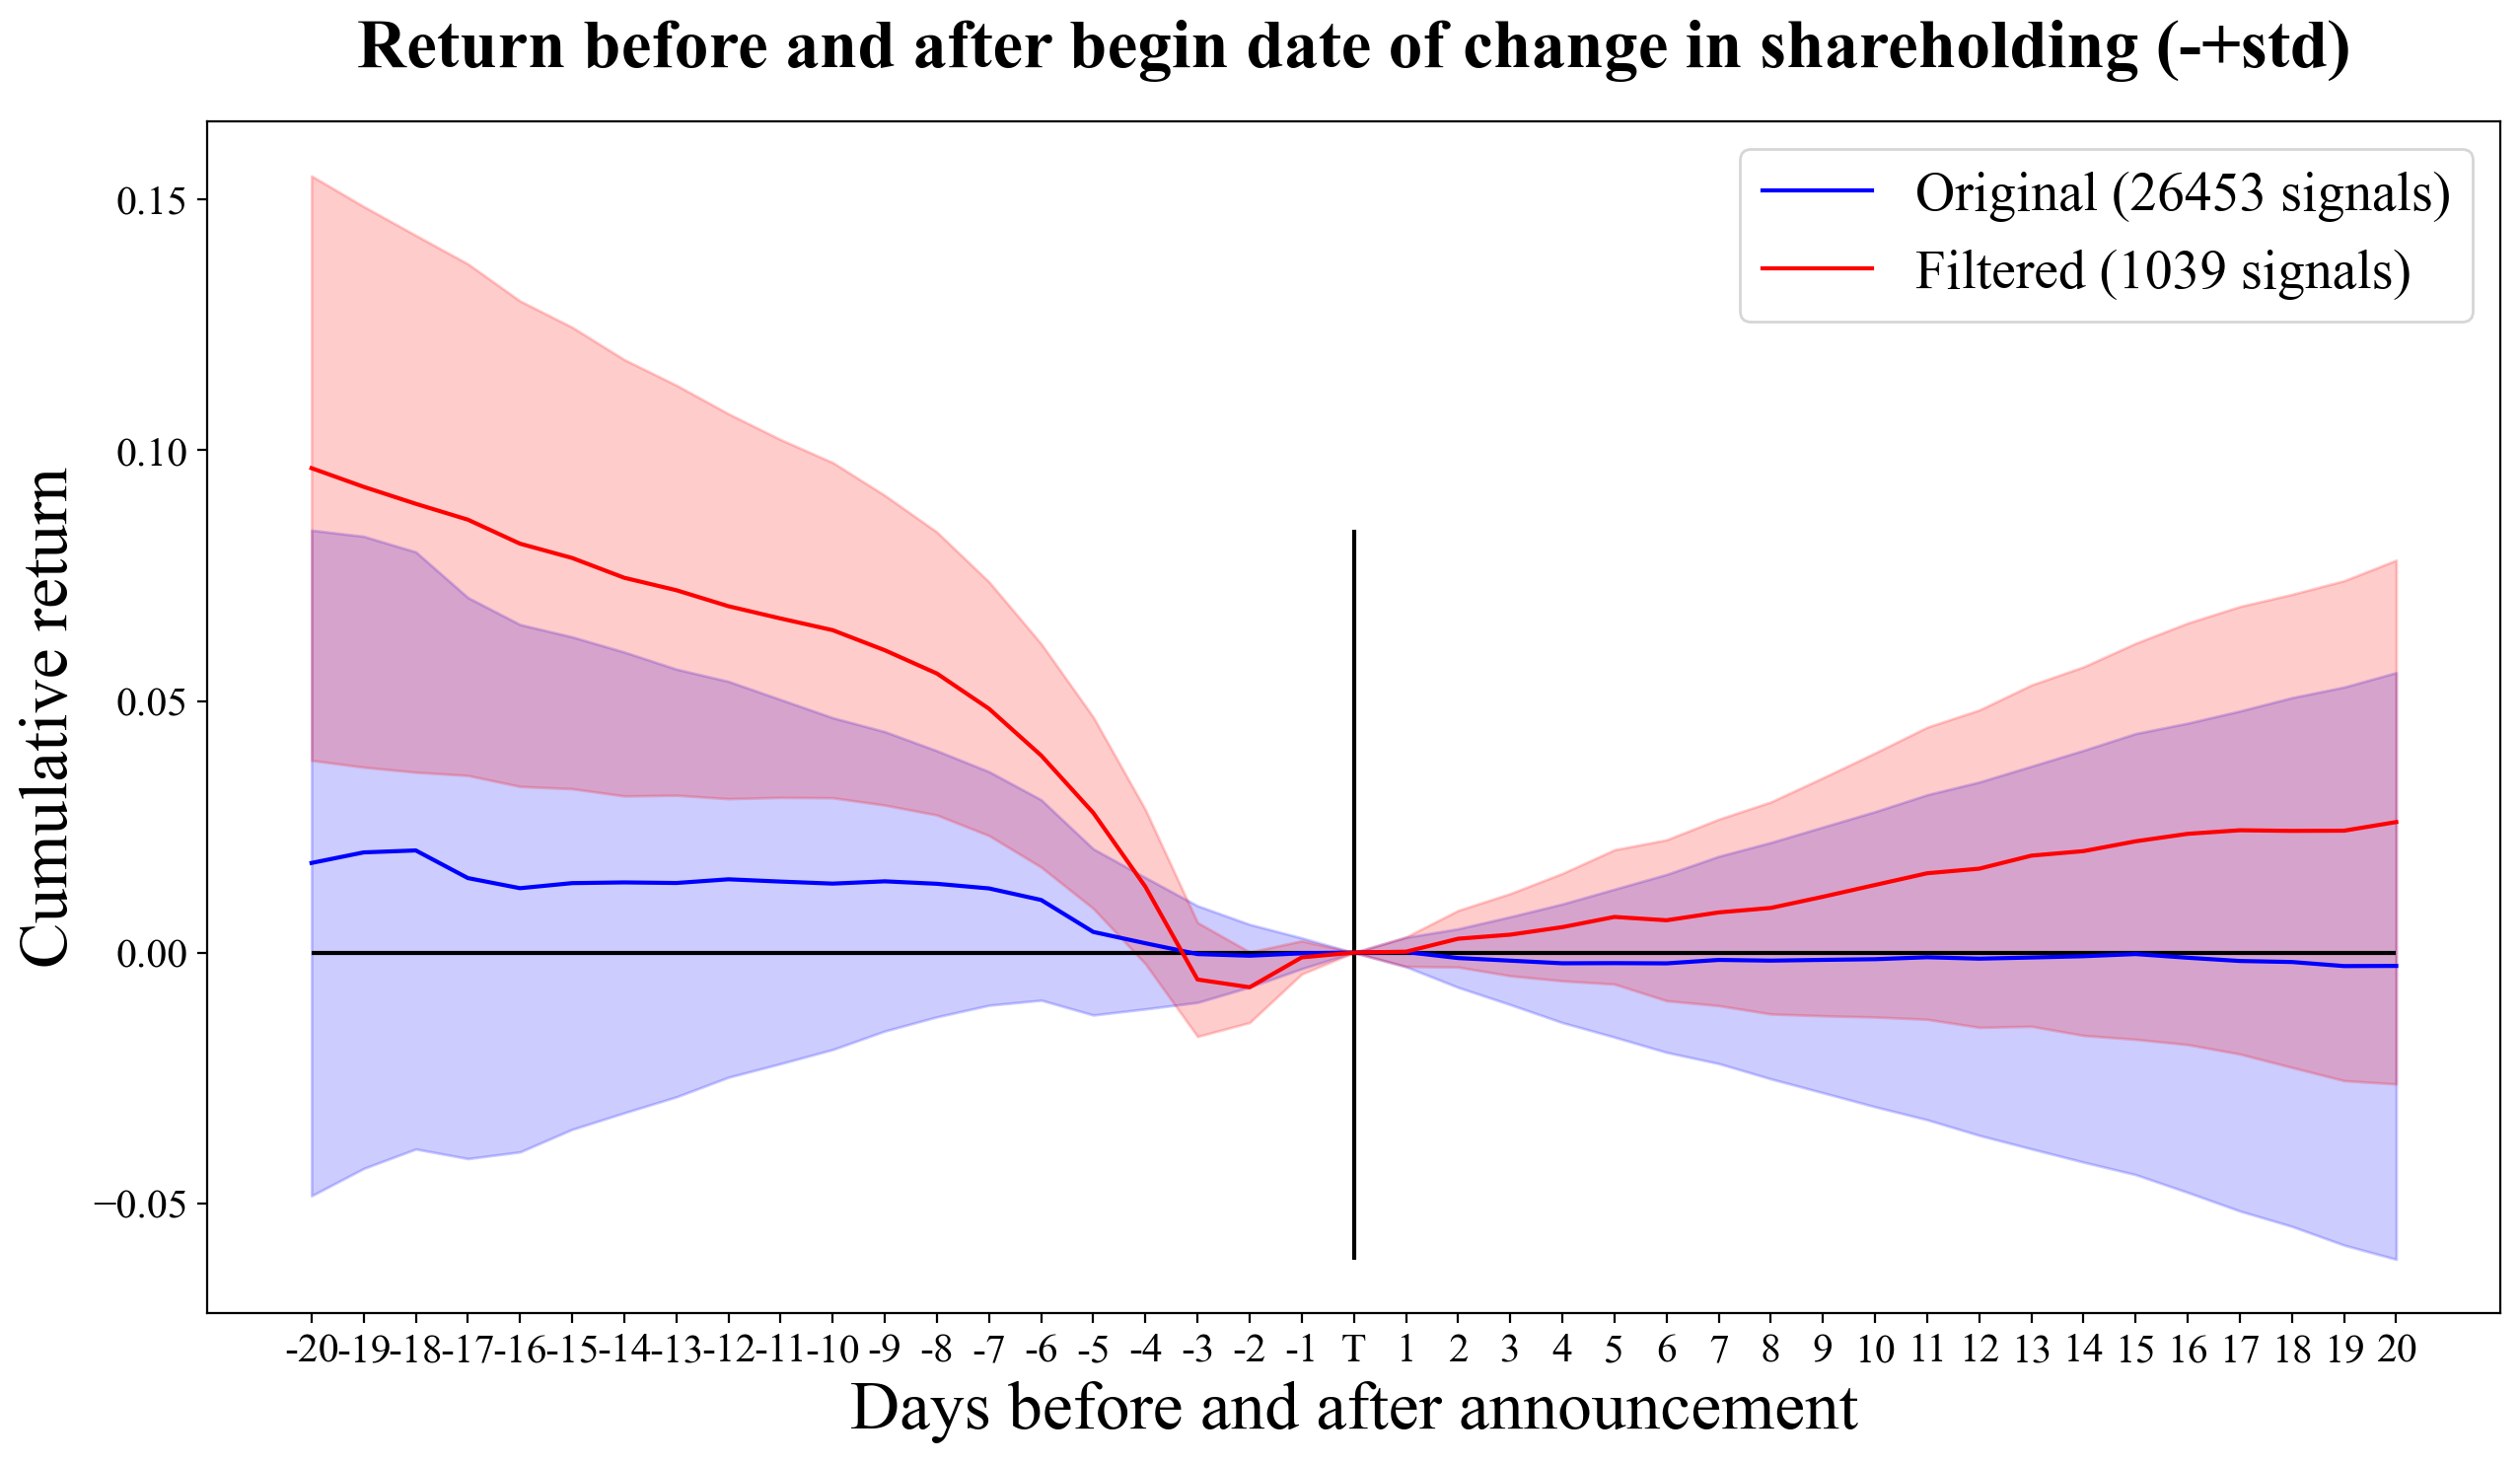

In [1273]:
a = draw_total(dfs = [chg_df_date,chg_df_part],date = 'BEGIN_DATE',name = 'begin date of change in shareholding')
a.savefig('/Users/jason/JC/公告数据/Figures/begin date of change in shareholding.jpg')



# 股权激励

## 描述性统计

In [214]:
#主要是股票偏多
exer_df_date.groupby(['SUBJECT2']).count().PUBLISH_DATE

SUBJECT2
1     721
2    1760
3       1
Name: PUBLISH_DATE, dtype: int64

In [215]:
exer_df.groupby(['MODE']).count().PUBLISH_DATE

MODE
3       5
4    1681
5      14
6     448
7     223
9     111
Name: PUBLISH_DATE, dtype: int64

In [216]:
exer_df.groupby(['SUBJECT2','MODE']).count().PUBLISH_DATE

SUBJECT2  MODE
1         4        208
          6        448
          7         24
          9         41
2         3          4
          4       1473
          5         14
          7        199
          9         70
3         3          1
Name: PUBLISH_DATE, dtype: int64

In [217]:
#原始数据是非常乱的，因此利用以下逻辑进行进一步的拆分
#以SUBJECT2为第一层筛选逻辑，以MODE为第二层筛选逻辑，避免冲突

In [218]:
subject_alt = []
mode_alt = []
a = exer_df.SUBJECT2
b = exer_df.MODE
for i in range(0,exer_df.shape[0]):
    if a[i] == 1 and b[i] == 4:
        subject_alt.append('option')
        #以前就是定向增发
        mode_alt.append('Private_Placement')
    elif a[i] == 1 and b[i] == 6:
        subject_alt.append('option')
        mode_alt.append('Private_Placement')
    elif a[i] == 1 and b[i] == 7:
        subject_alt.append('option')
        mode_alt.append('Buy_Back')
    elif a[i] == 1 and b[i] == 9:
        subject_alt.append('option')
        mode_alt.append('Hand_Over')
    elif a[i] == 2 and b[i] == 4:
        subject_alt.append('stock')
        mode_alt.append('Private_Placement')
    elif a[i] == 2 and b[i] == 7:
        subject_alt.append('stock')
        mode_alt.append('Buy_Back')
    elif a[i] == 2 and b[i] == 9:
        subject_alt.append('stock')
        mode_alt.append('Hand_Over')
    else:
        subject_alt.append(np.nan)
        mode_alt.append(np.nan)

In [219]:
exer_df_date['SUBJECT_ALT'] = subject_alt
exer_df_date['MODE_ALT'] = mode_alt
#将其他的填充为others，基本上为股票增值权
exer_df_date[['SUBJECT_ALT','MODE_ALT']] = exer_df_date[['SUBJECT_ALT','MODE_ALT']].fillna('Others')

In [904]:
exer_des_df = exer_df_date.groupby(['SUBJECT_ALT','MODE_ALT']).count().PUBLISH_DATE

In [916]:
exer_des_df1 = exer_des_df.unstack().fillna(0).iloc[1:,:]

In [957]:
def draw_stack(pct_draw_df,name,name2,size=9):
    pct_draw_df = (pct_draw_df.fillna(0).T/pct_draw_df.fillna(0).sum(axis=1)).T
    Ind = pct_draw_df.fillna(0).T.sum(axis=1).sort_values(ascending = False).index
    s = pct_draw_df[Ind].fillna(0).cumsum(axis=1)

    plt.figure(figsize=(size,8),dpi=200)
    plt.xlim(-1.7,2)
    for i in range(0,len(Ind)):
        plt.bar([-1,0],s.iloc[:,len(Ind)-i-1])
    a = list(Ind)
    a.reverse()
    plt.legend(a,fontsize=16)

    plt.xticks([-1,0],s.index,fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(name,size=30)
    
    return plt

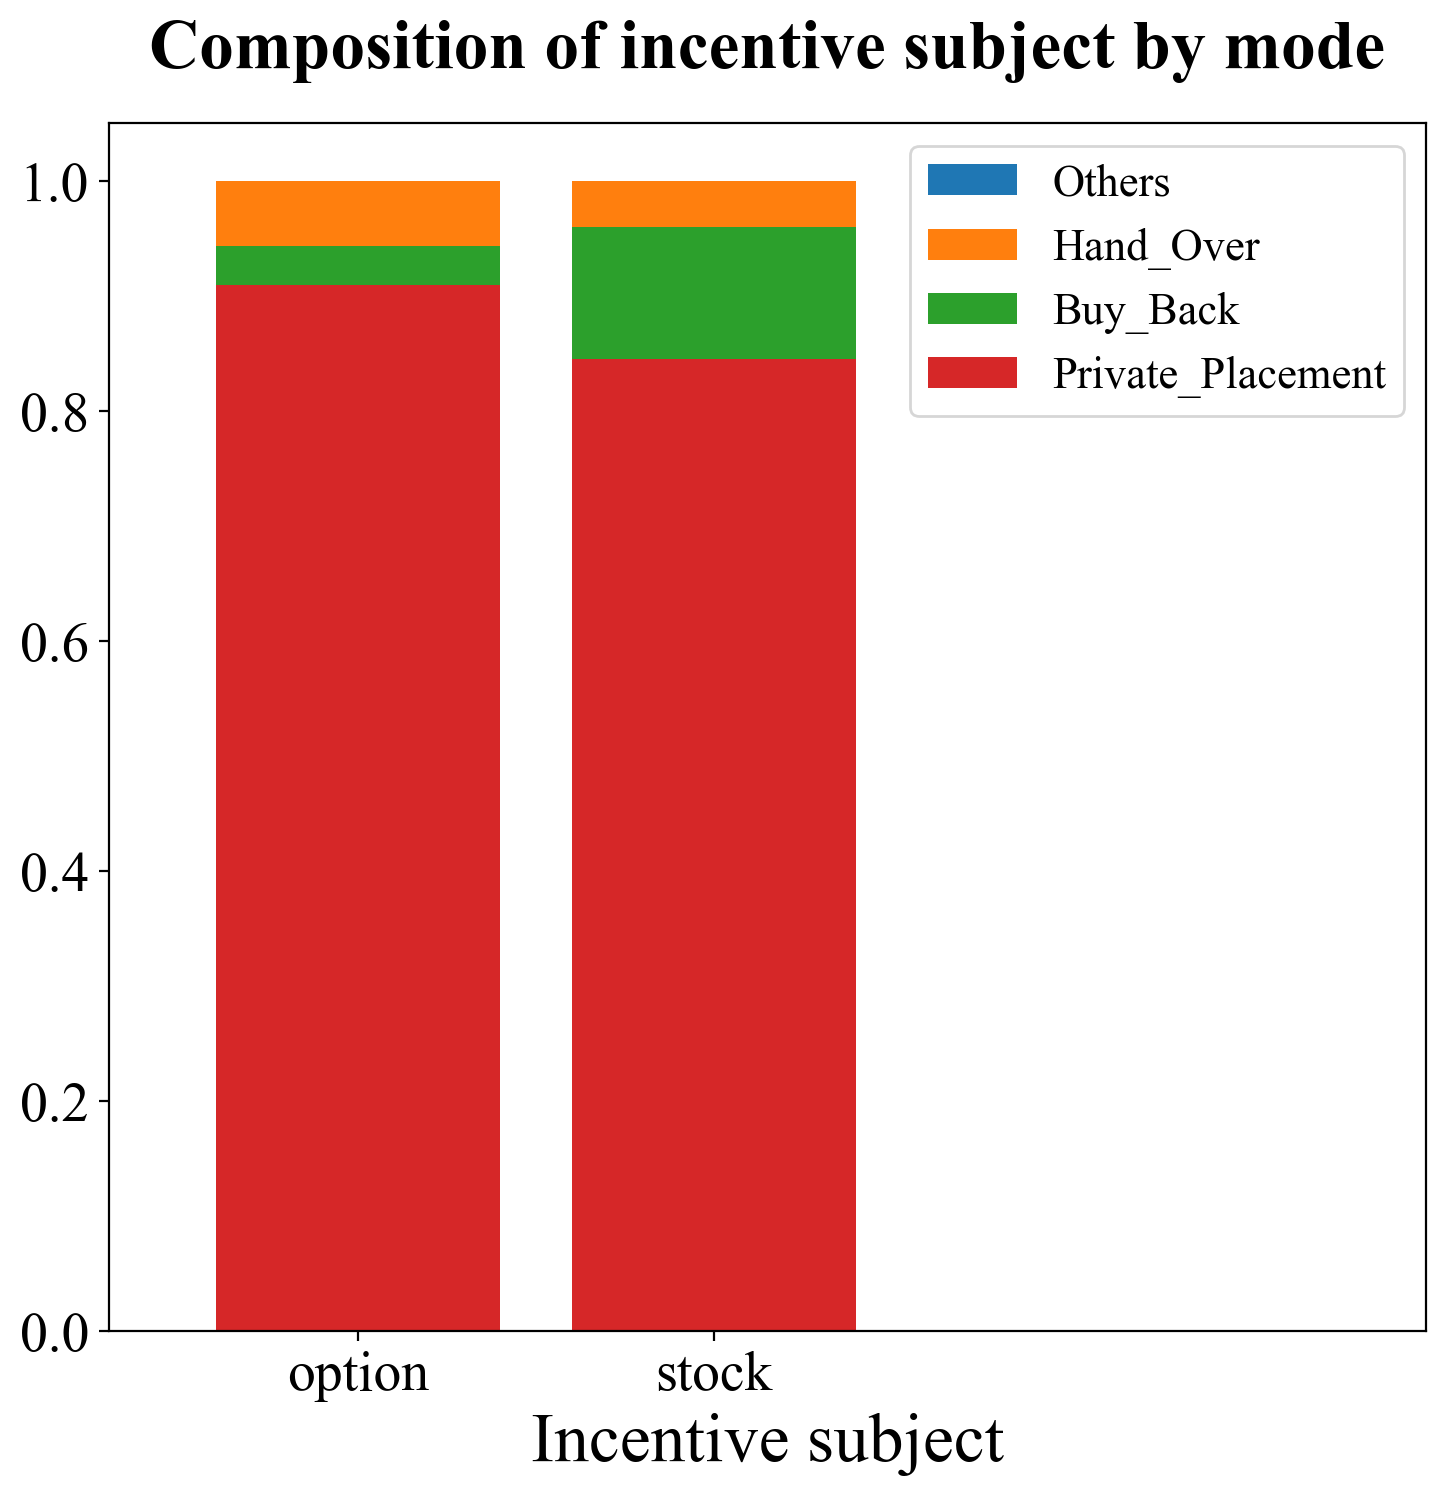

In [1247]:
a = draw_stack(exer_des_df1,name="Incentive subject",name2 = "Composition of incentive subject by mode",size=8.5)
a.savefig("/Users/jason/JC/公告数据/Figures/Incentive subject pie.jpg")


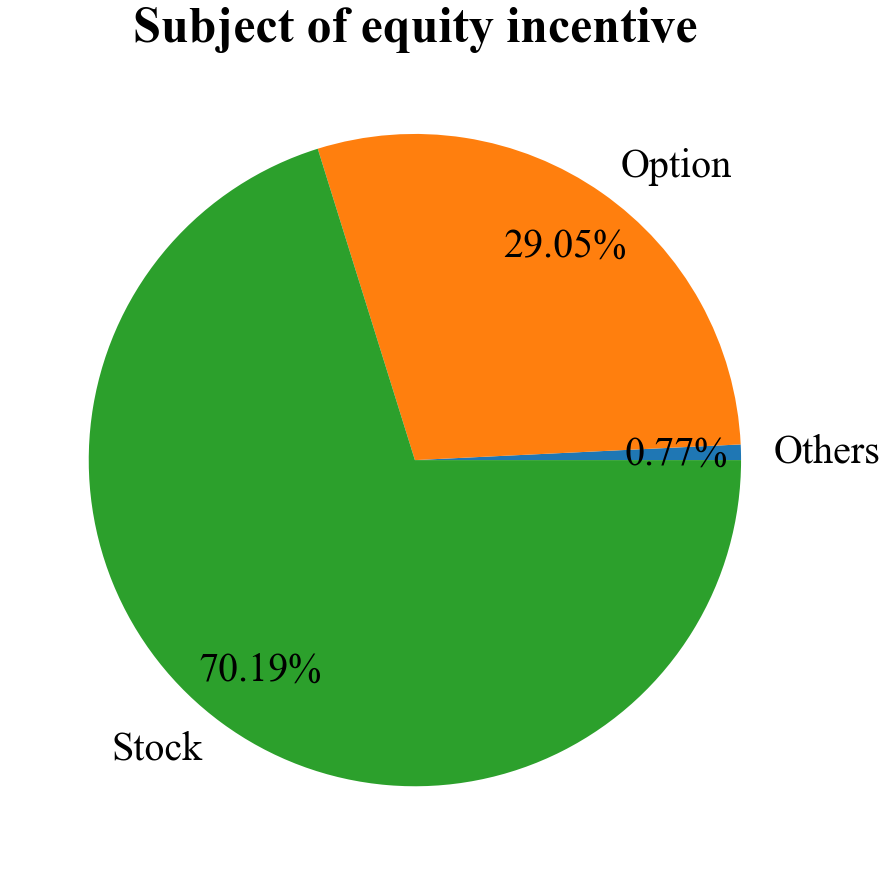

In [1246]:
denom = exer_df_date.groupby(['SUBJECT_ALT']).count()['mar']
plt.figure(figsize=(15,15))
plt.pie(denom,labels=['Others','Option','Stock'],autopct='%.2f%%',pctdistance=0.8,
        textprops={'fontsize': 40, 'color': 'black'})
#plt.legend(pct_draw_df.columns,fontsize=5,loc='center right')
plt.title('Subject of equity incentive',fontsize=50,pad=10,fontproperties='Times New Roman',fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Exer PIE.jpg')

## 分事件测试

(2106, 14)
(1684, 14)


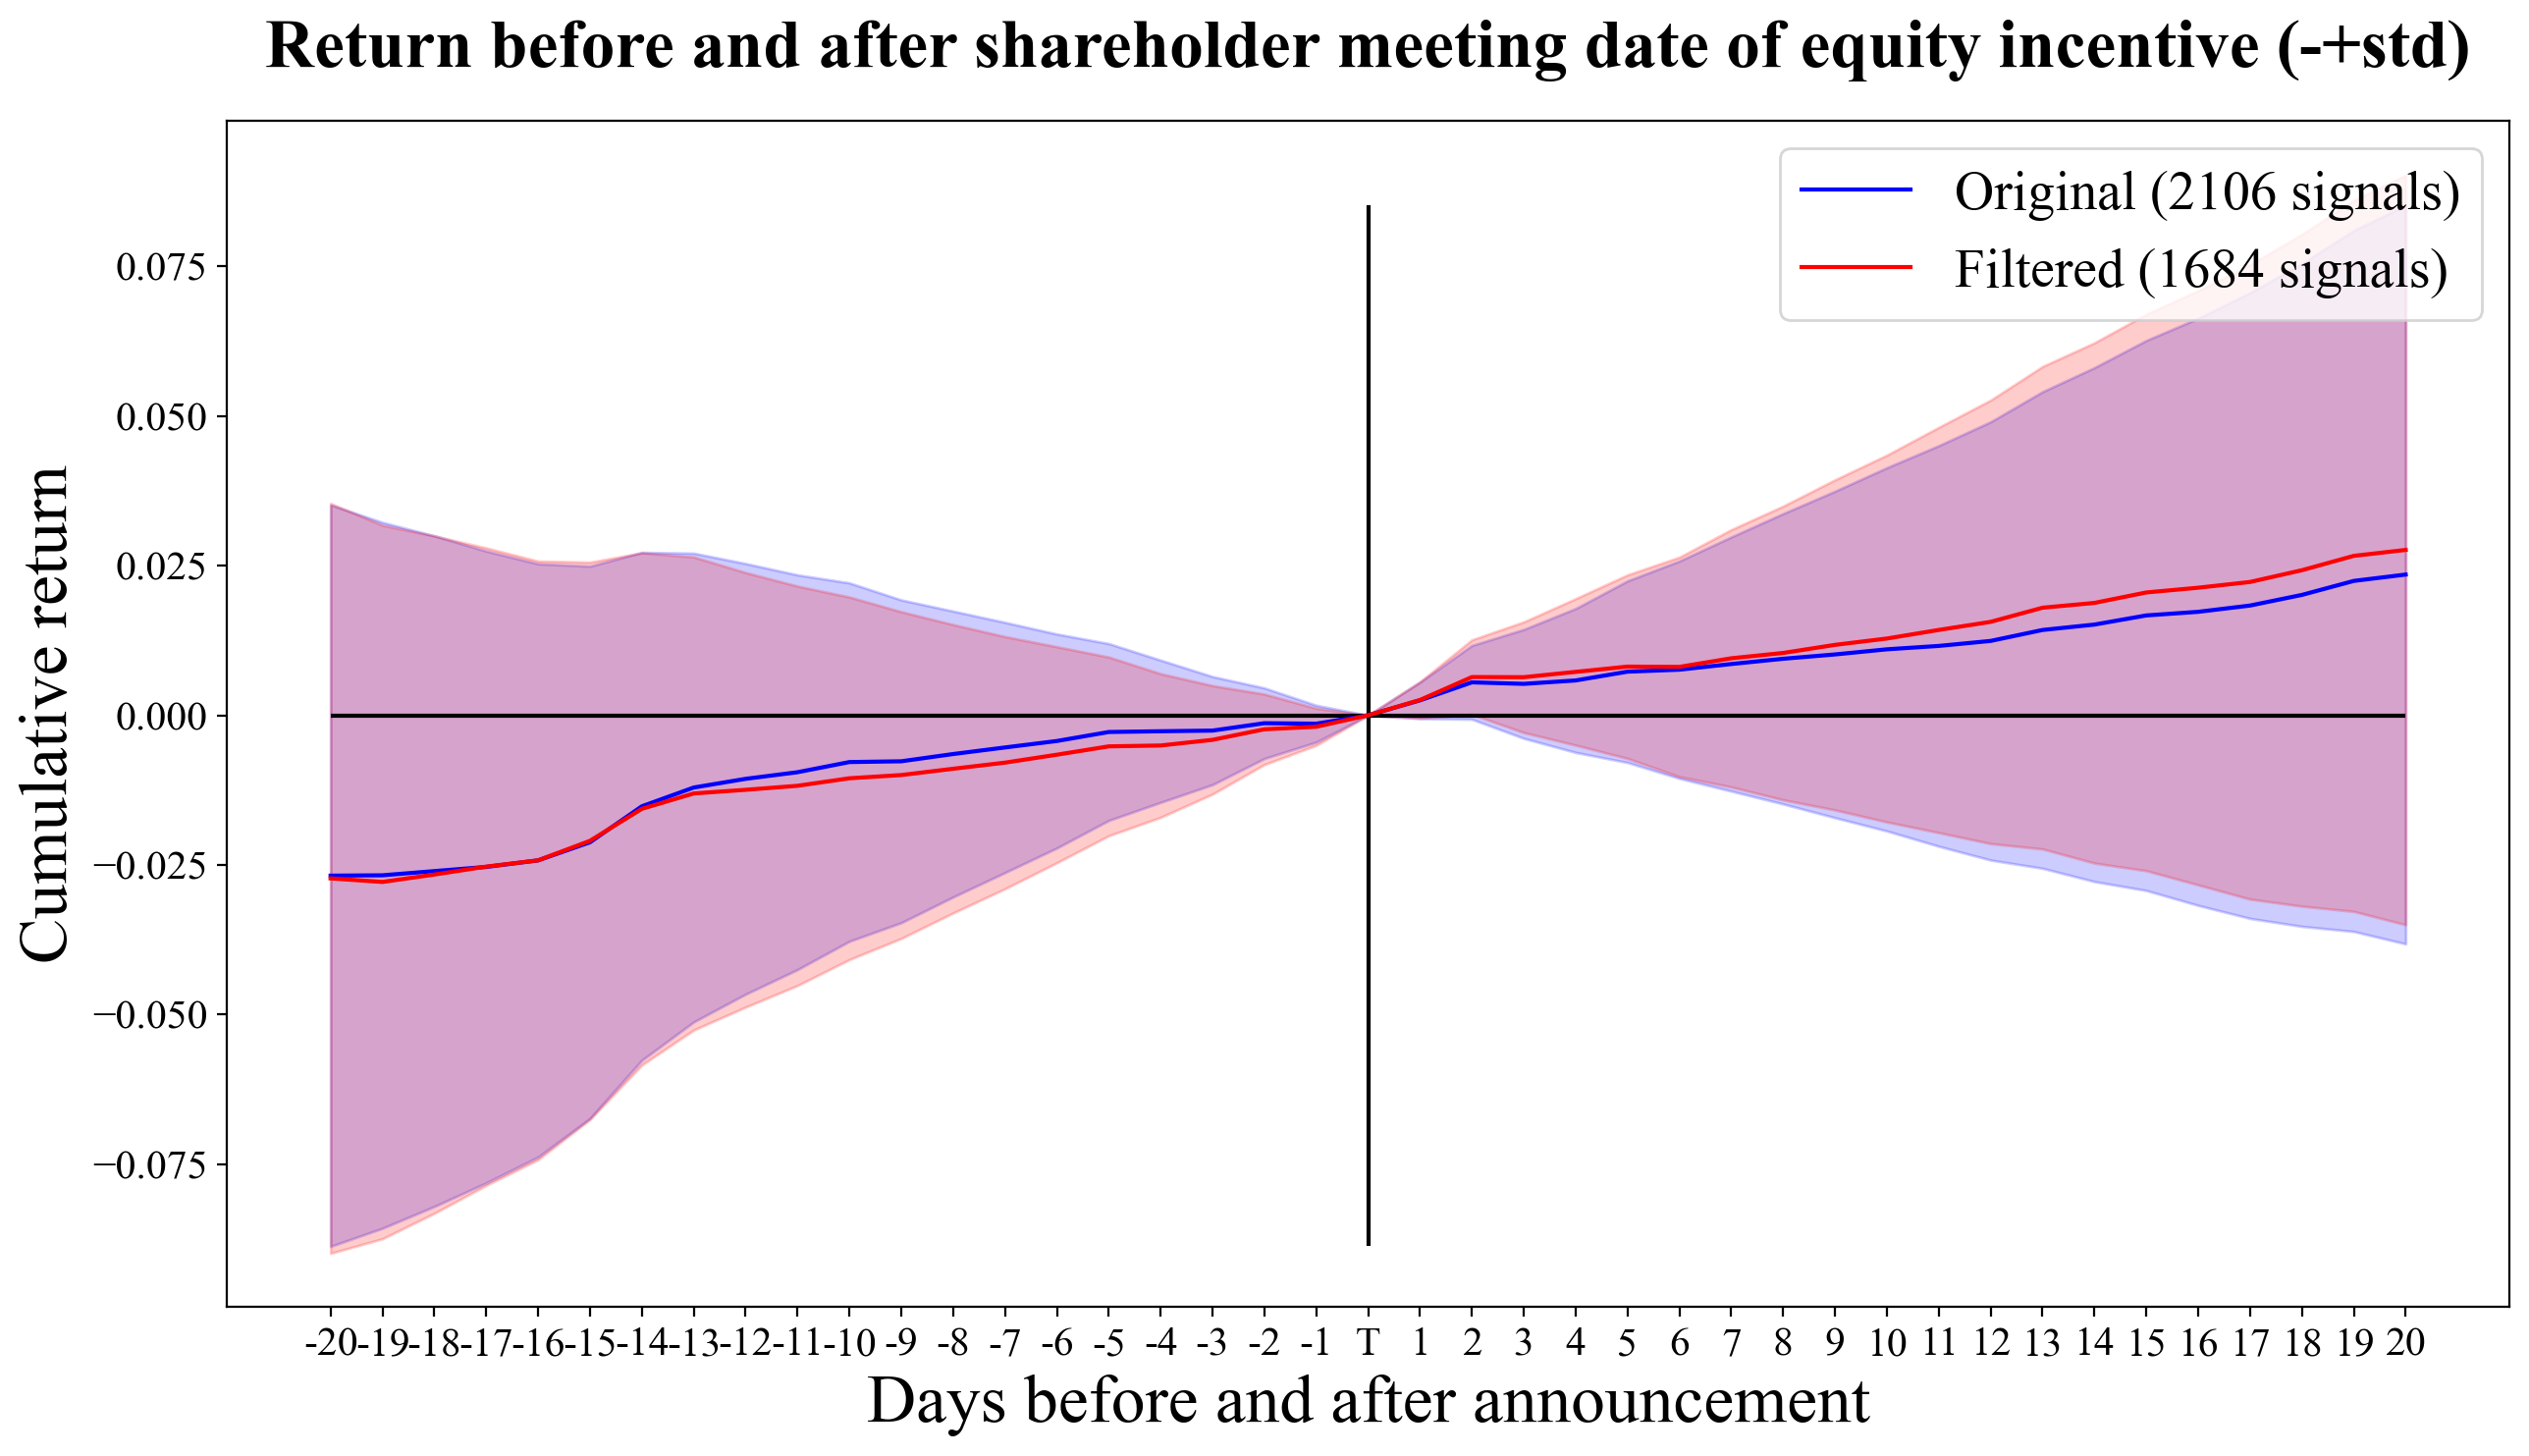

In [1274]:
a = draw_total(dfs = [exer_df_date,exer_df_part],date = 'SHC_DATE',name = 'shareholder meeting date of equity incentive')
a.savefig('/Users/jason/JC/公告数据/Figures/shareholder meeting date of equity incentive.jpg')


(2446, 14)
(1779, 14)


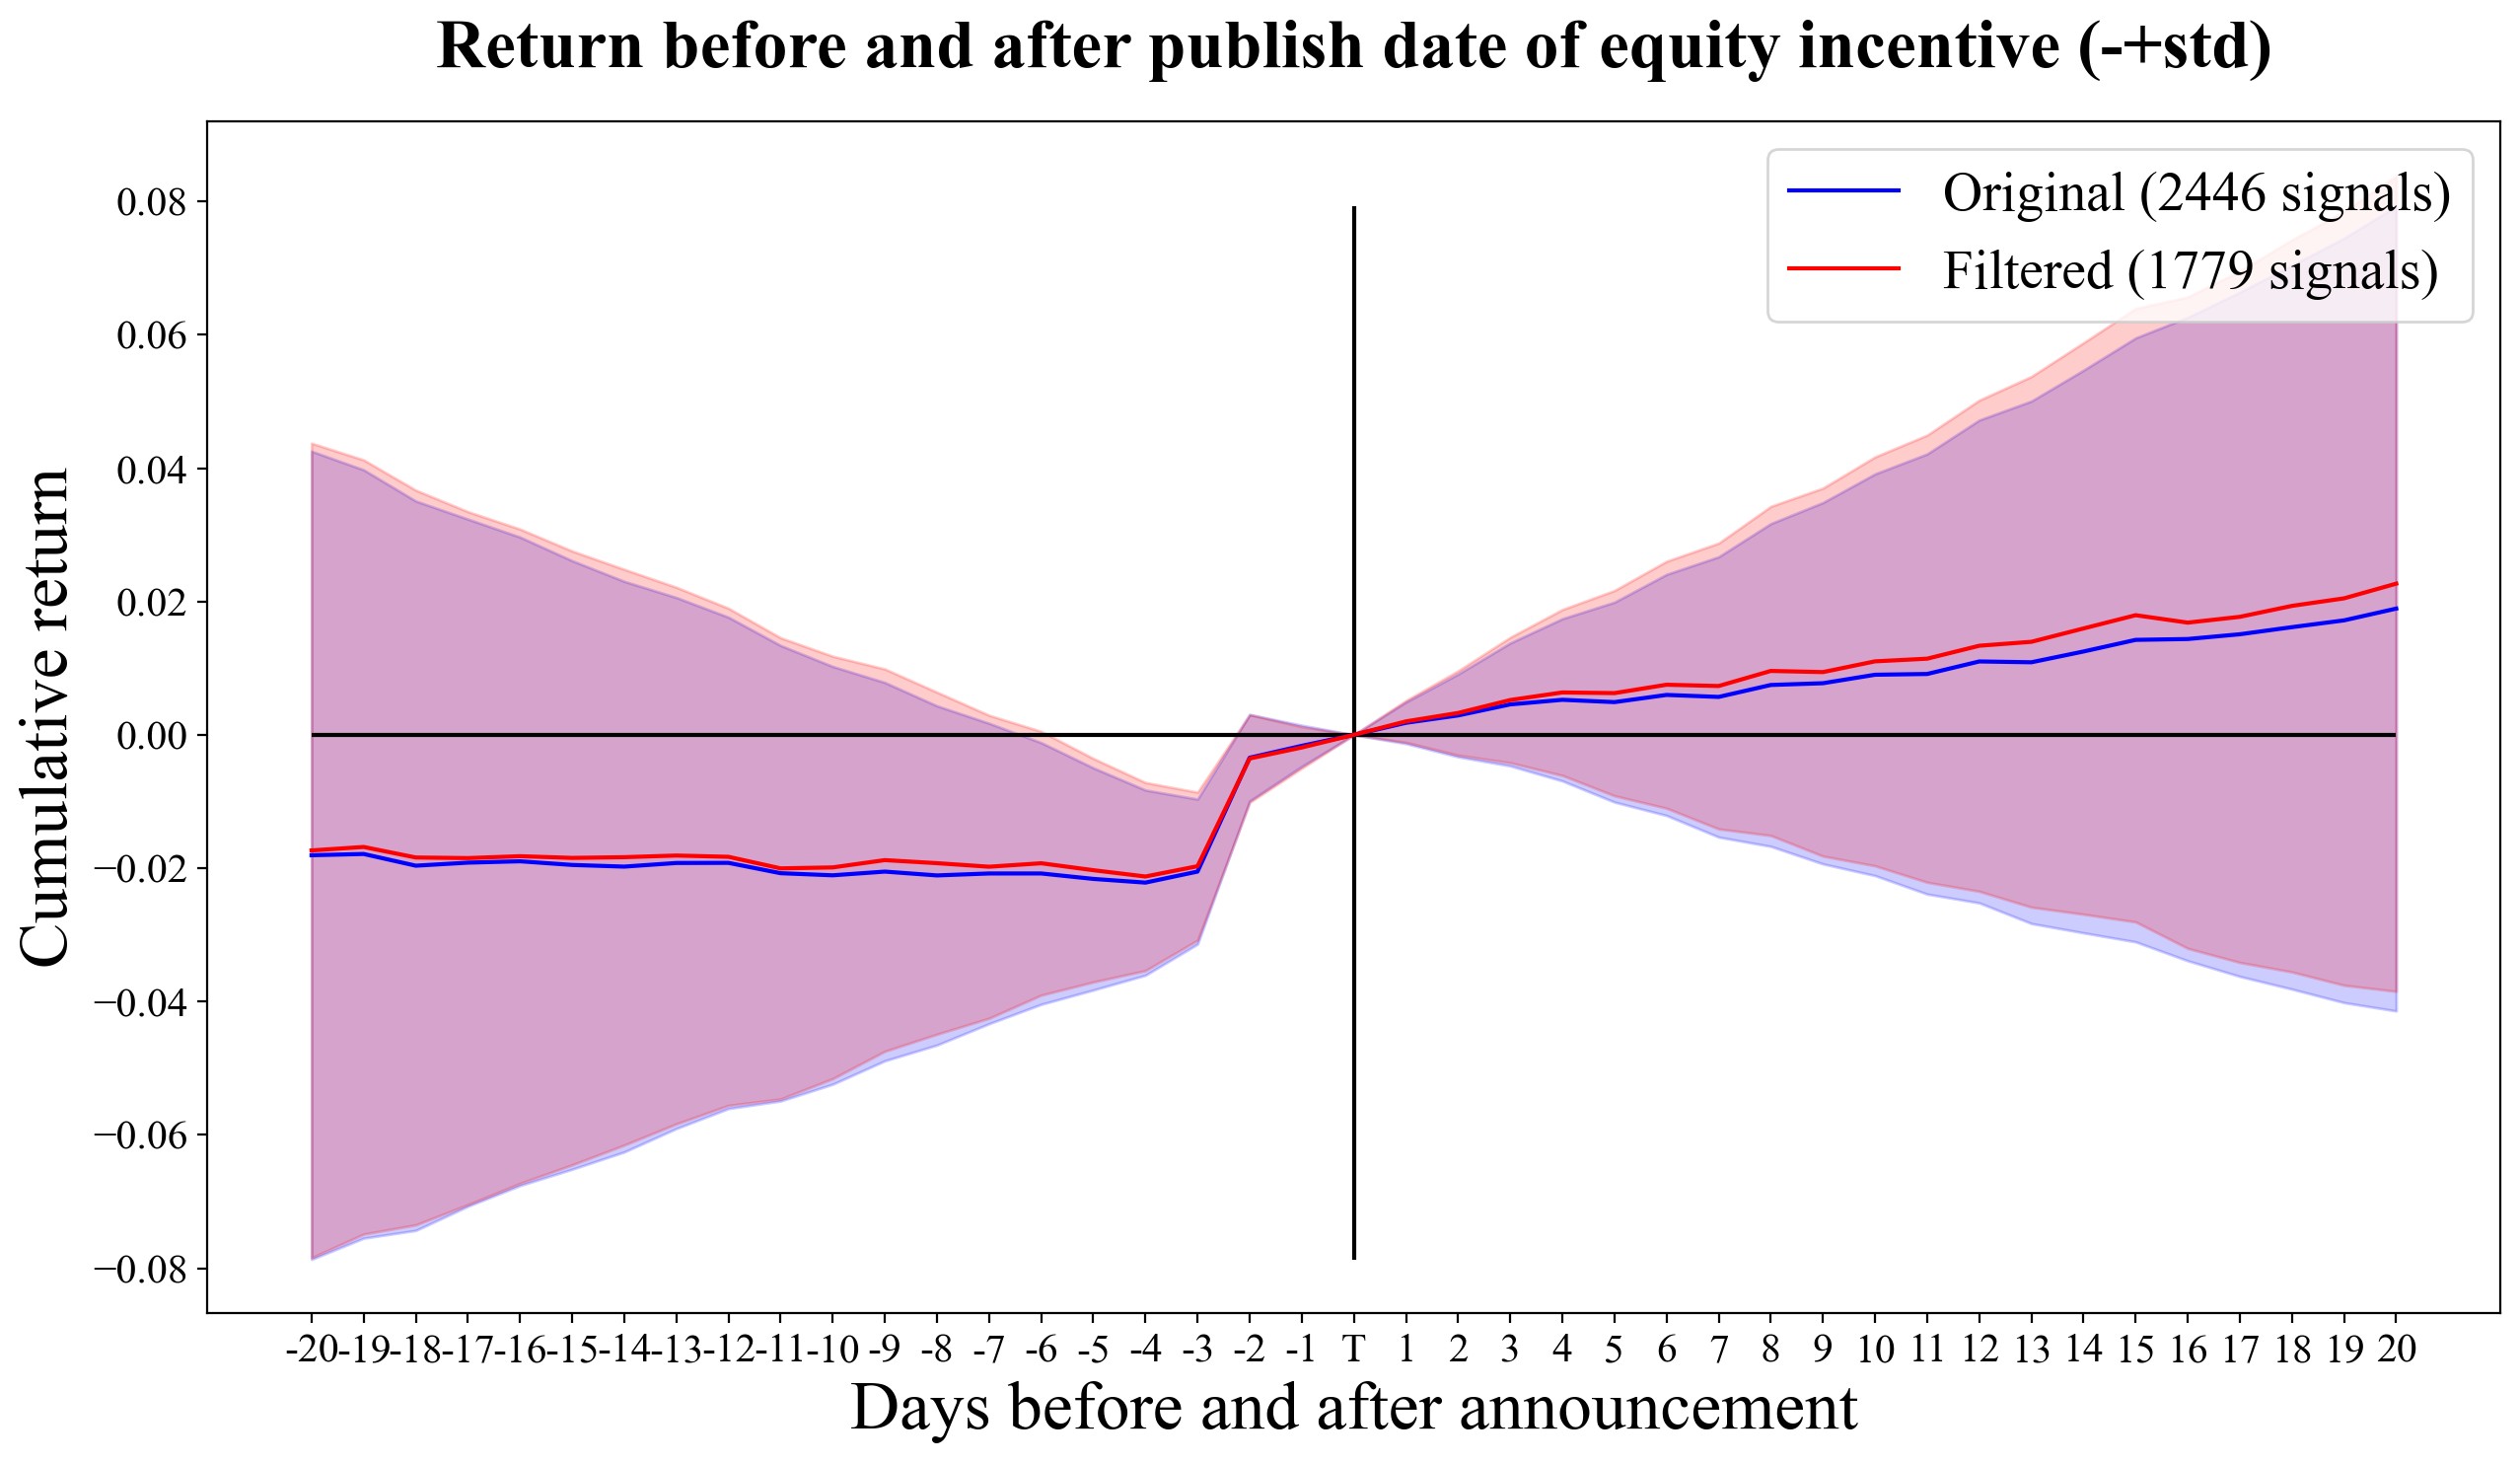

In [1275]:
a = draw_total(dfs = [exer_df_date,exer_df_part],date = 'PUBLISH_DATE',name = 'publish date of equity incentive')
a.savefig('/Users/jason/JC/公告数据/Figures/publish date of equity incentive.jpg')


(2007, 14)
(1605, 14)


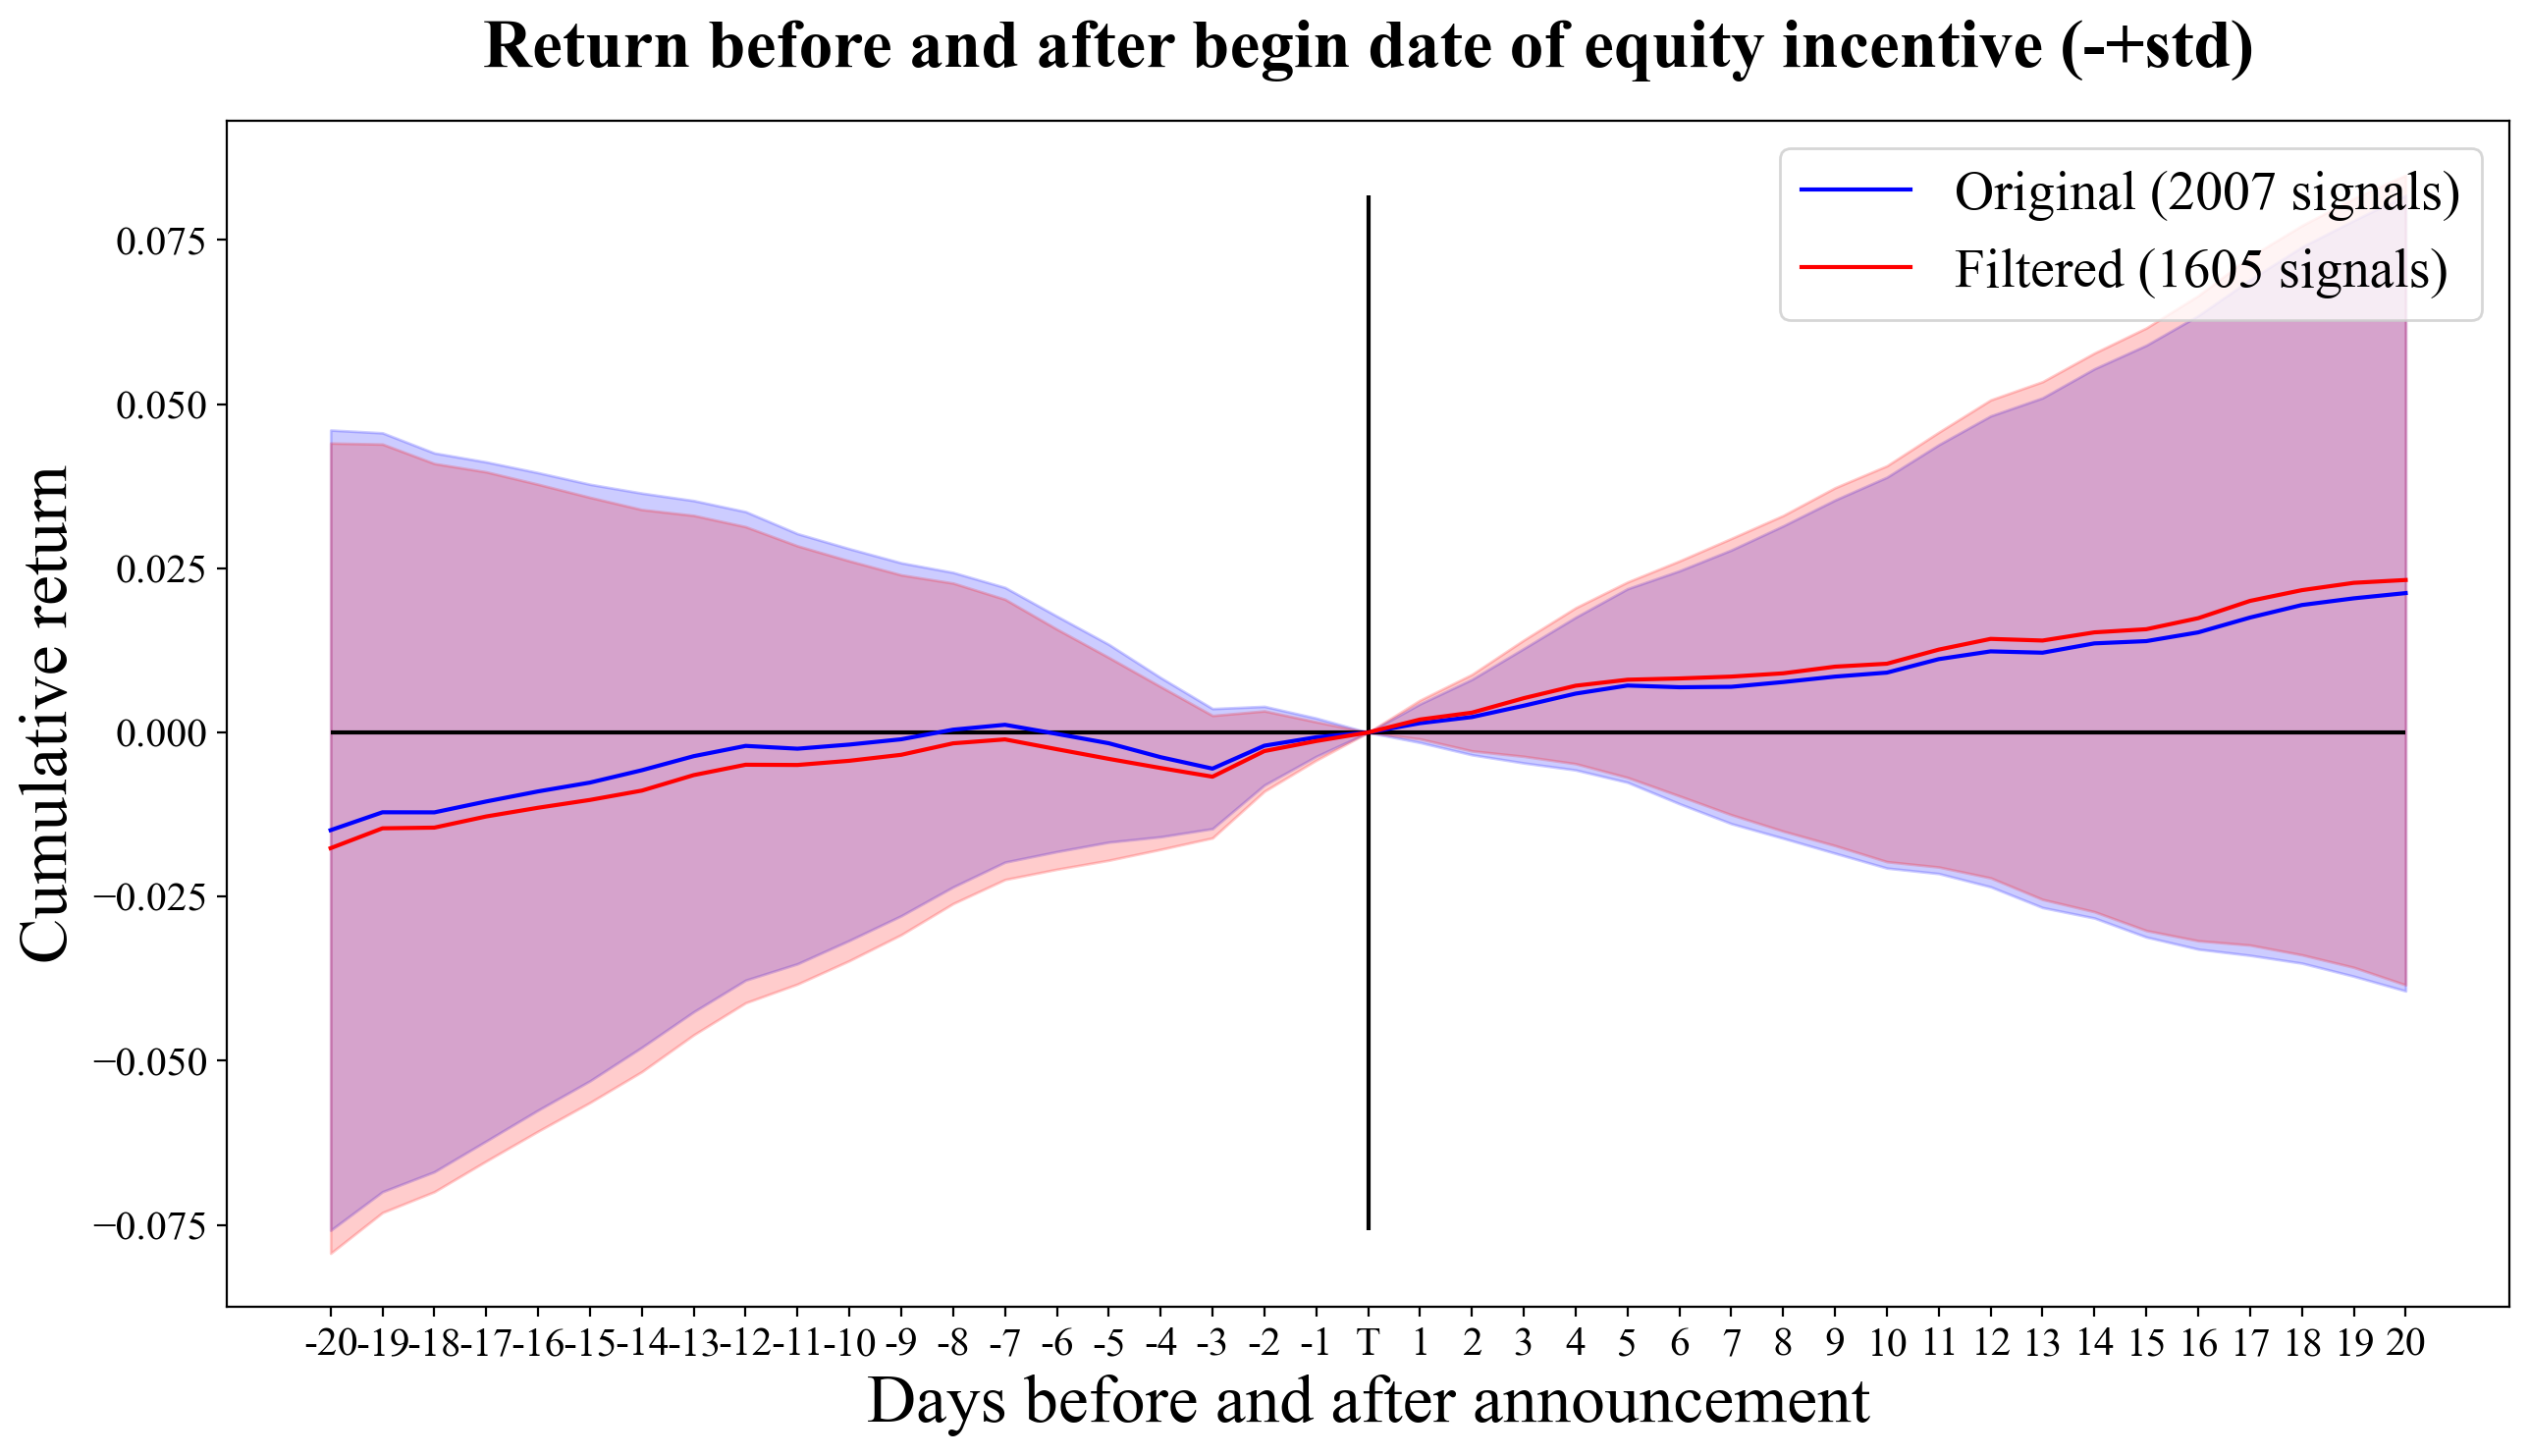

In [1276]:
a = draw_total(dfs = [exer_df_date,exer_df_part],date = 'INI_DATE',name = 'begin date of equity incentive')
a.savefig('/Users/jason/JC/公告数据/Figures/begin date of equity incentive.jpg')


## 策略

In [221]:
exer_df_part = exer_df_date[
    ((exer_df_date.SUBJECT_ALT=='stock'))|(exer_df_date.MODE_ALT=='Hand_Over') |
(exer_df_date.MODE_ALT=='Buy_Back')]


# 回购

## 描述性统计

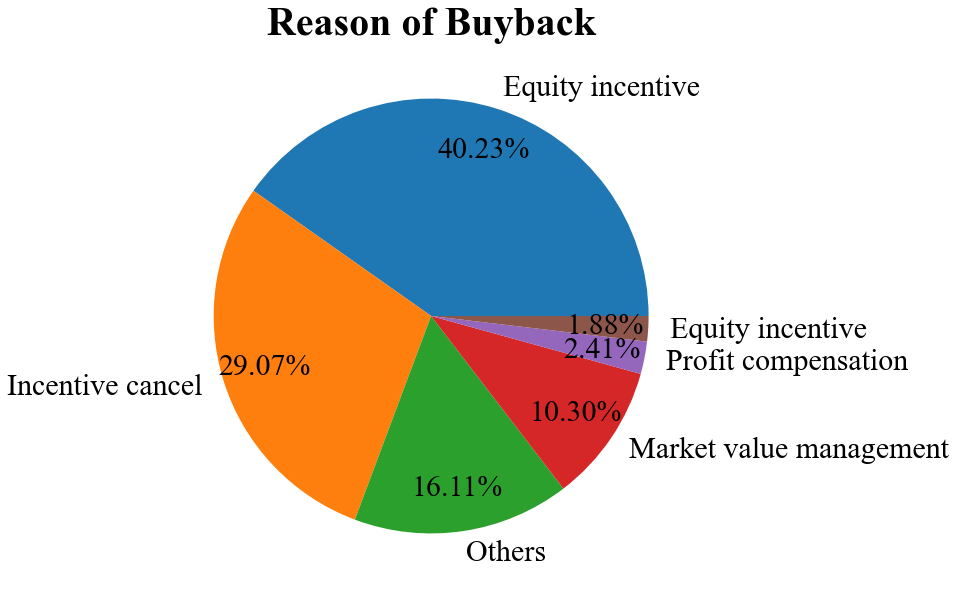

In [1253]:
denom = buy_back_date.BUY_BACK_TYPE.value_counts()
plt.figure(figsize=(10,10))
plt.pie(denom,labels=['Equity incentive','Incentive cancel','Others',
           'Market value management','Profit compensation','Equity incentive'],autopct='%.2f%%',pctdistance=0.8,
        textprops={'fontsize': 30, 'color': 'black'})
#plt.legend(pct_draw_df.columns,fontsize=5,loc='center right')
plt.title('Reason of Buyback',fontsize=40,pad=10,fontproperties='Times New Roman',fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/buyback PIE.jpg')

## 分事件测试

(14969, 11)
(1833, 11)


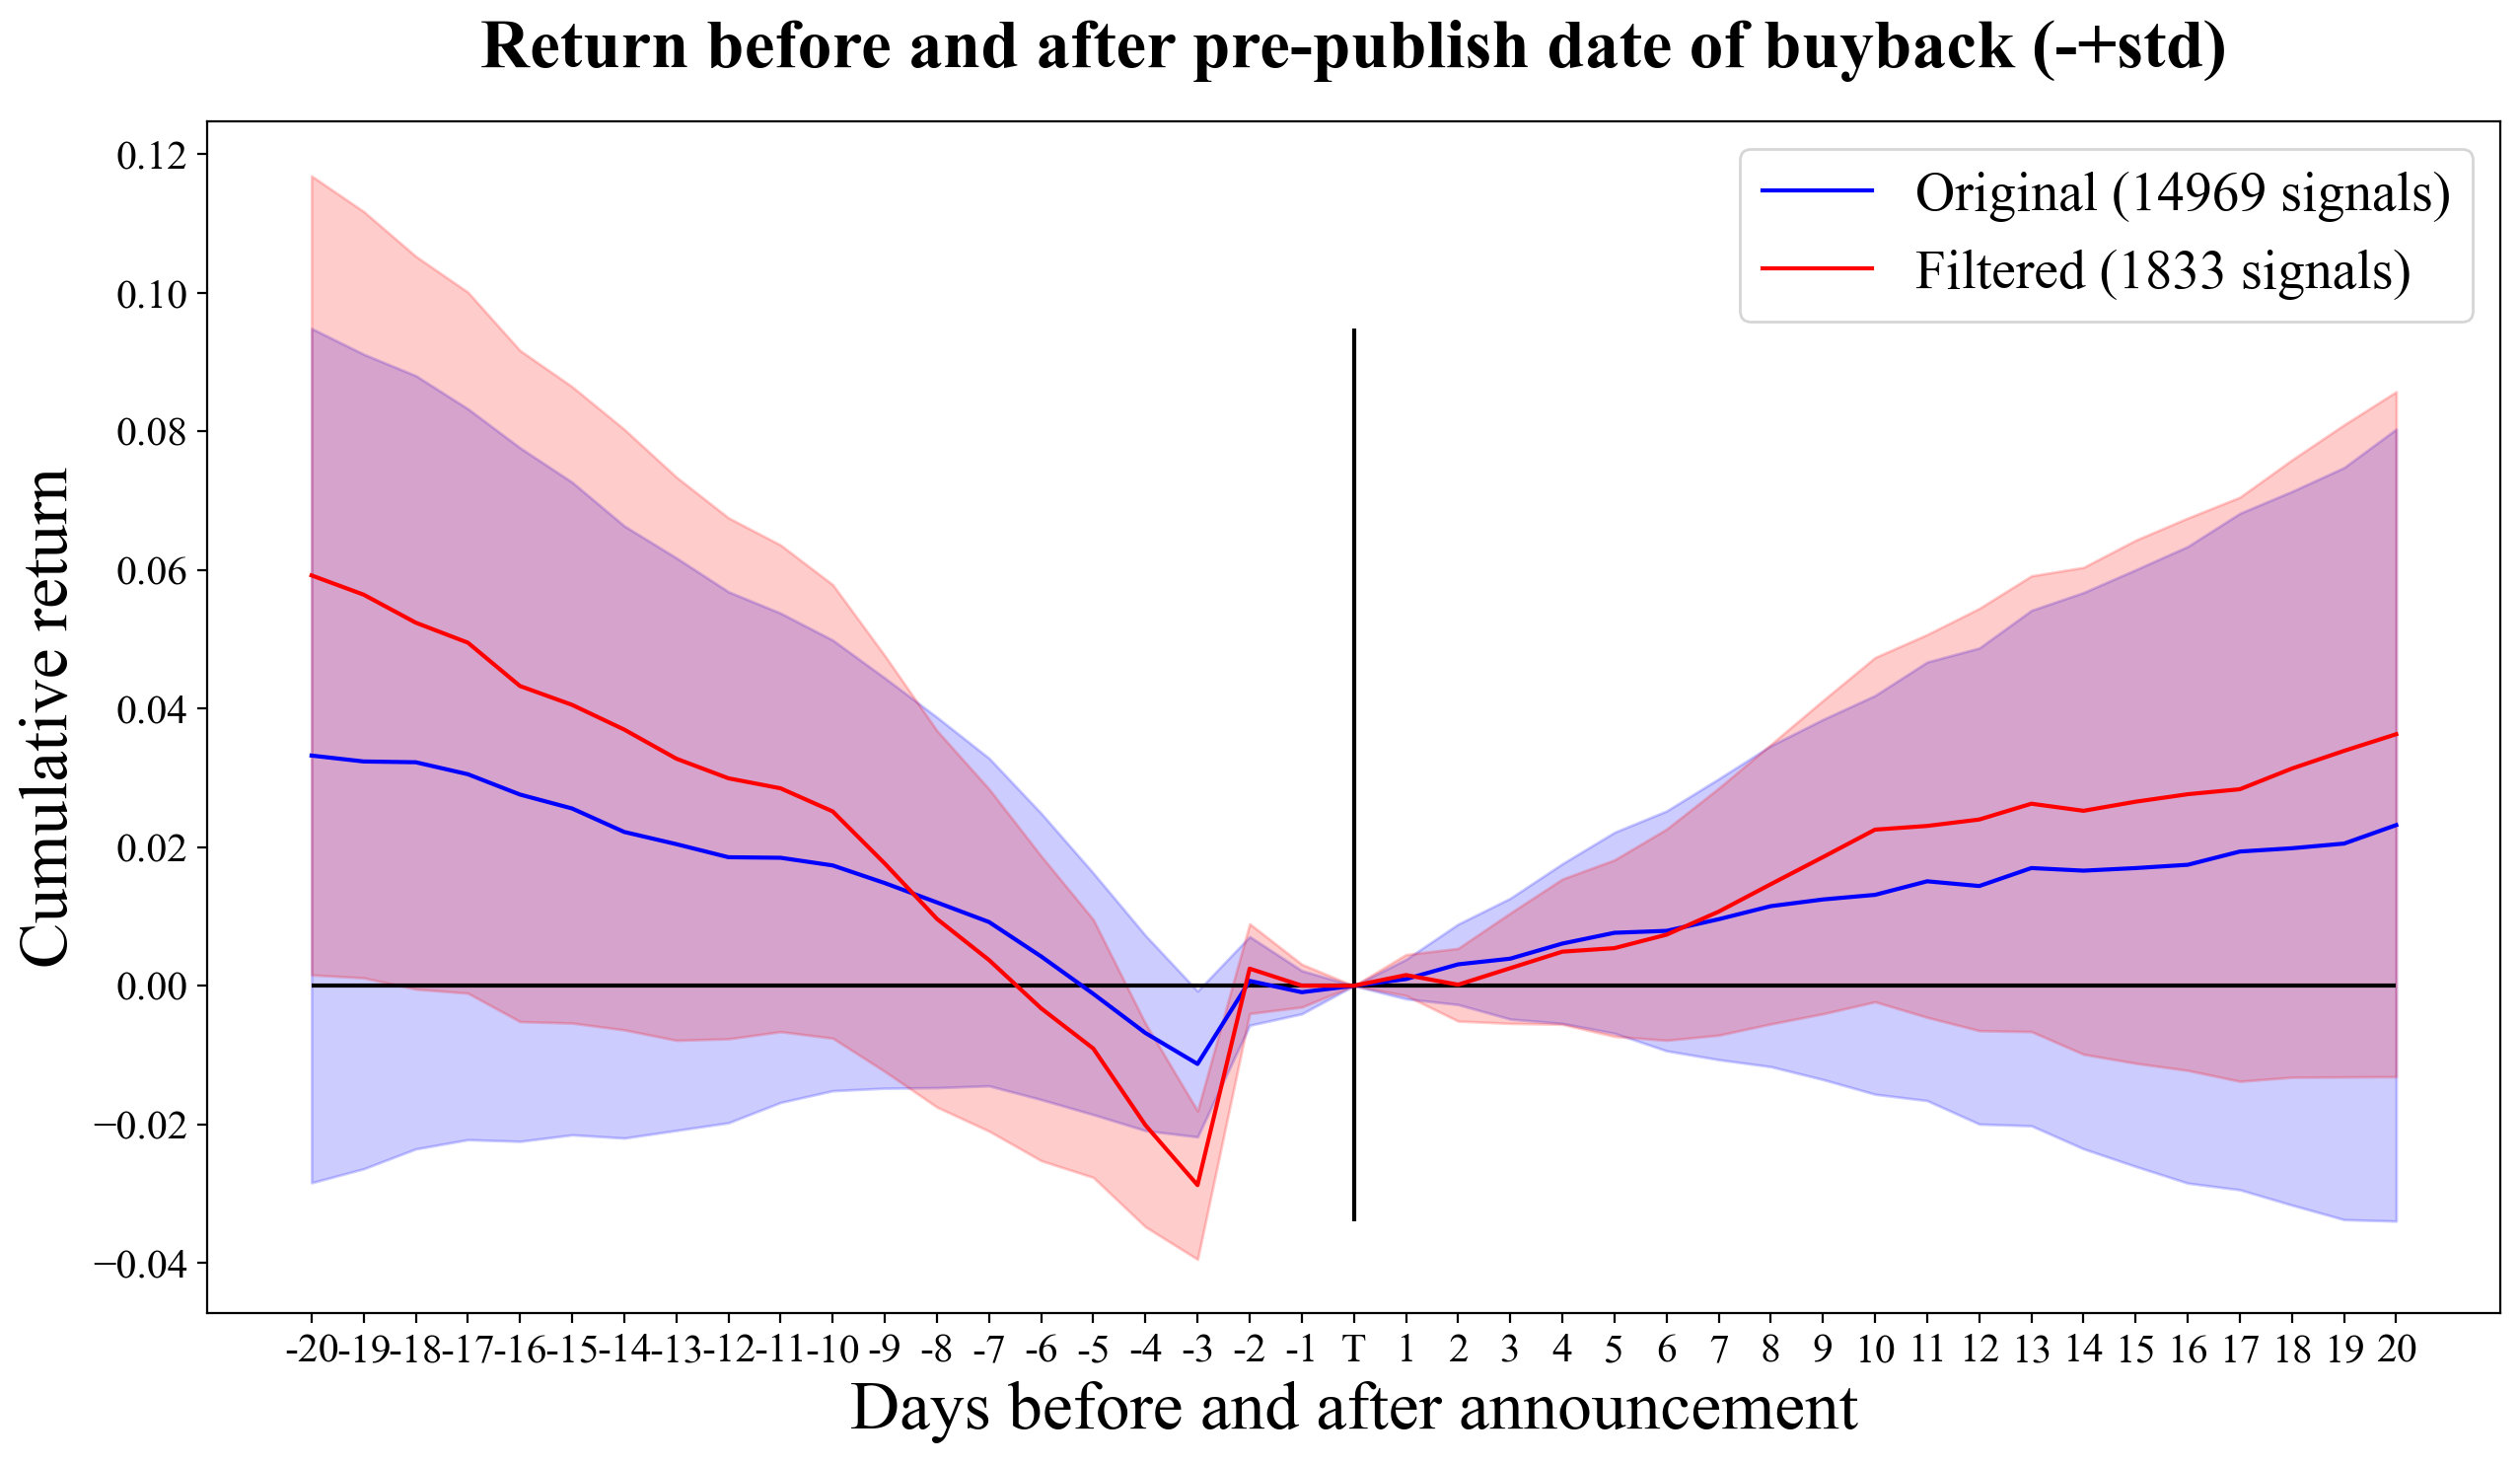

In [1284]:
a = draw_total(dfs = [buy_back_date,buy_back_part],date = 'PRE_PUB_DATE',name = 'pre-publish date of buyback')
a.savefig('/Users/jason/JC/公告数据/Figures/pre-publish date of buyback.jpg')

## 策略

In [224]:
buy_back_part = buy_back_date[(buy_back_date.BUY_BACK_TYPE==3)
                  | (buy_back_date.BUY_BACK_TYPE==6)]

In [225]:
buy_back_part.count()

Unnamed: 0          1834
TICKER_SYMBOL       1834
PRE_PUB_DATE        1834
PUBLISH_DATE        1812
BUY_BACK_TYPE       1834
BUY_BACK_PROCESS    1834
VALUE_UPL           1832
VALUE_LL            1627
BUY_BACK_VALUE      1809
PRICE_UPL           1834
PRICE_LL              37
dtype: int64

(13942, 11)
(1774, 11)


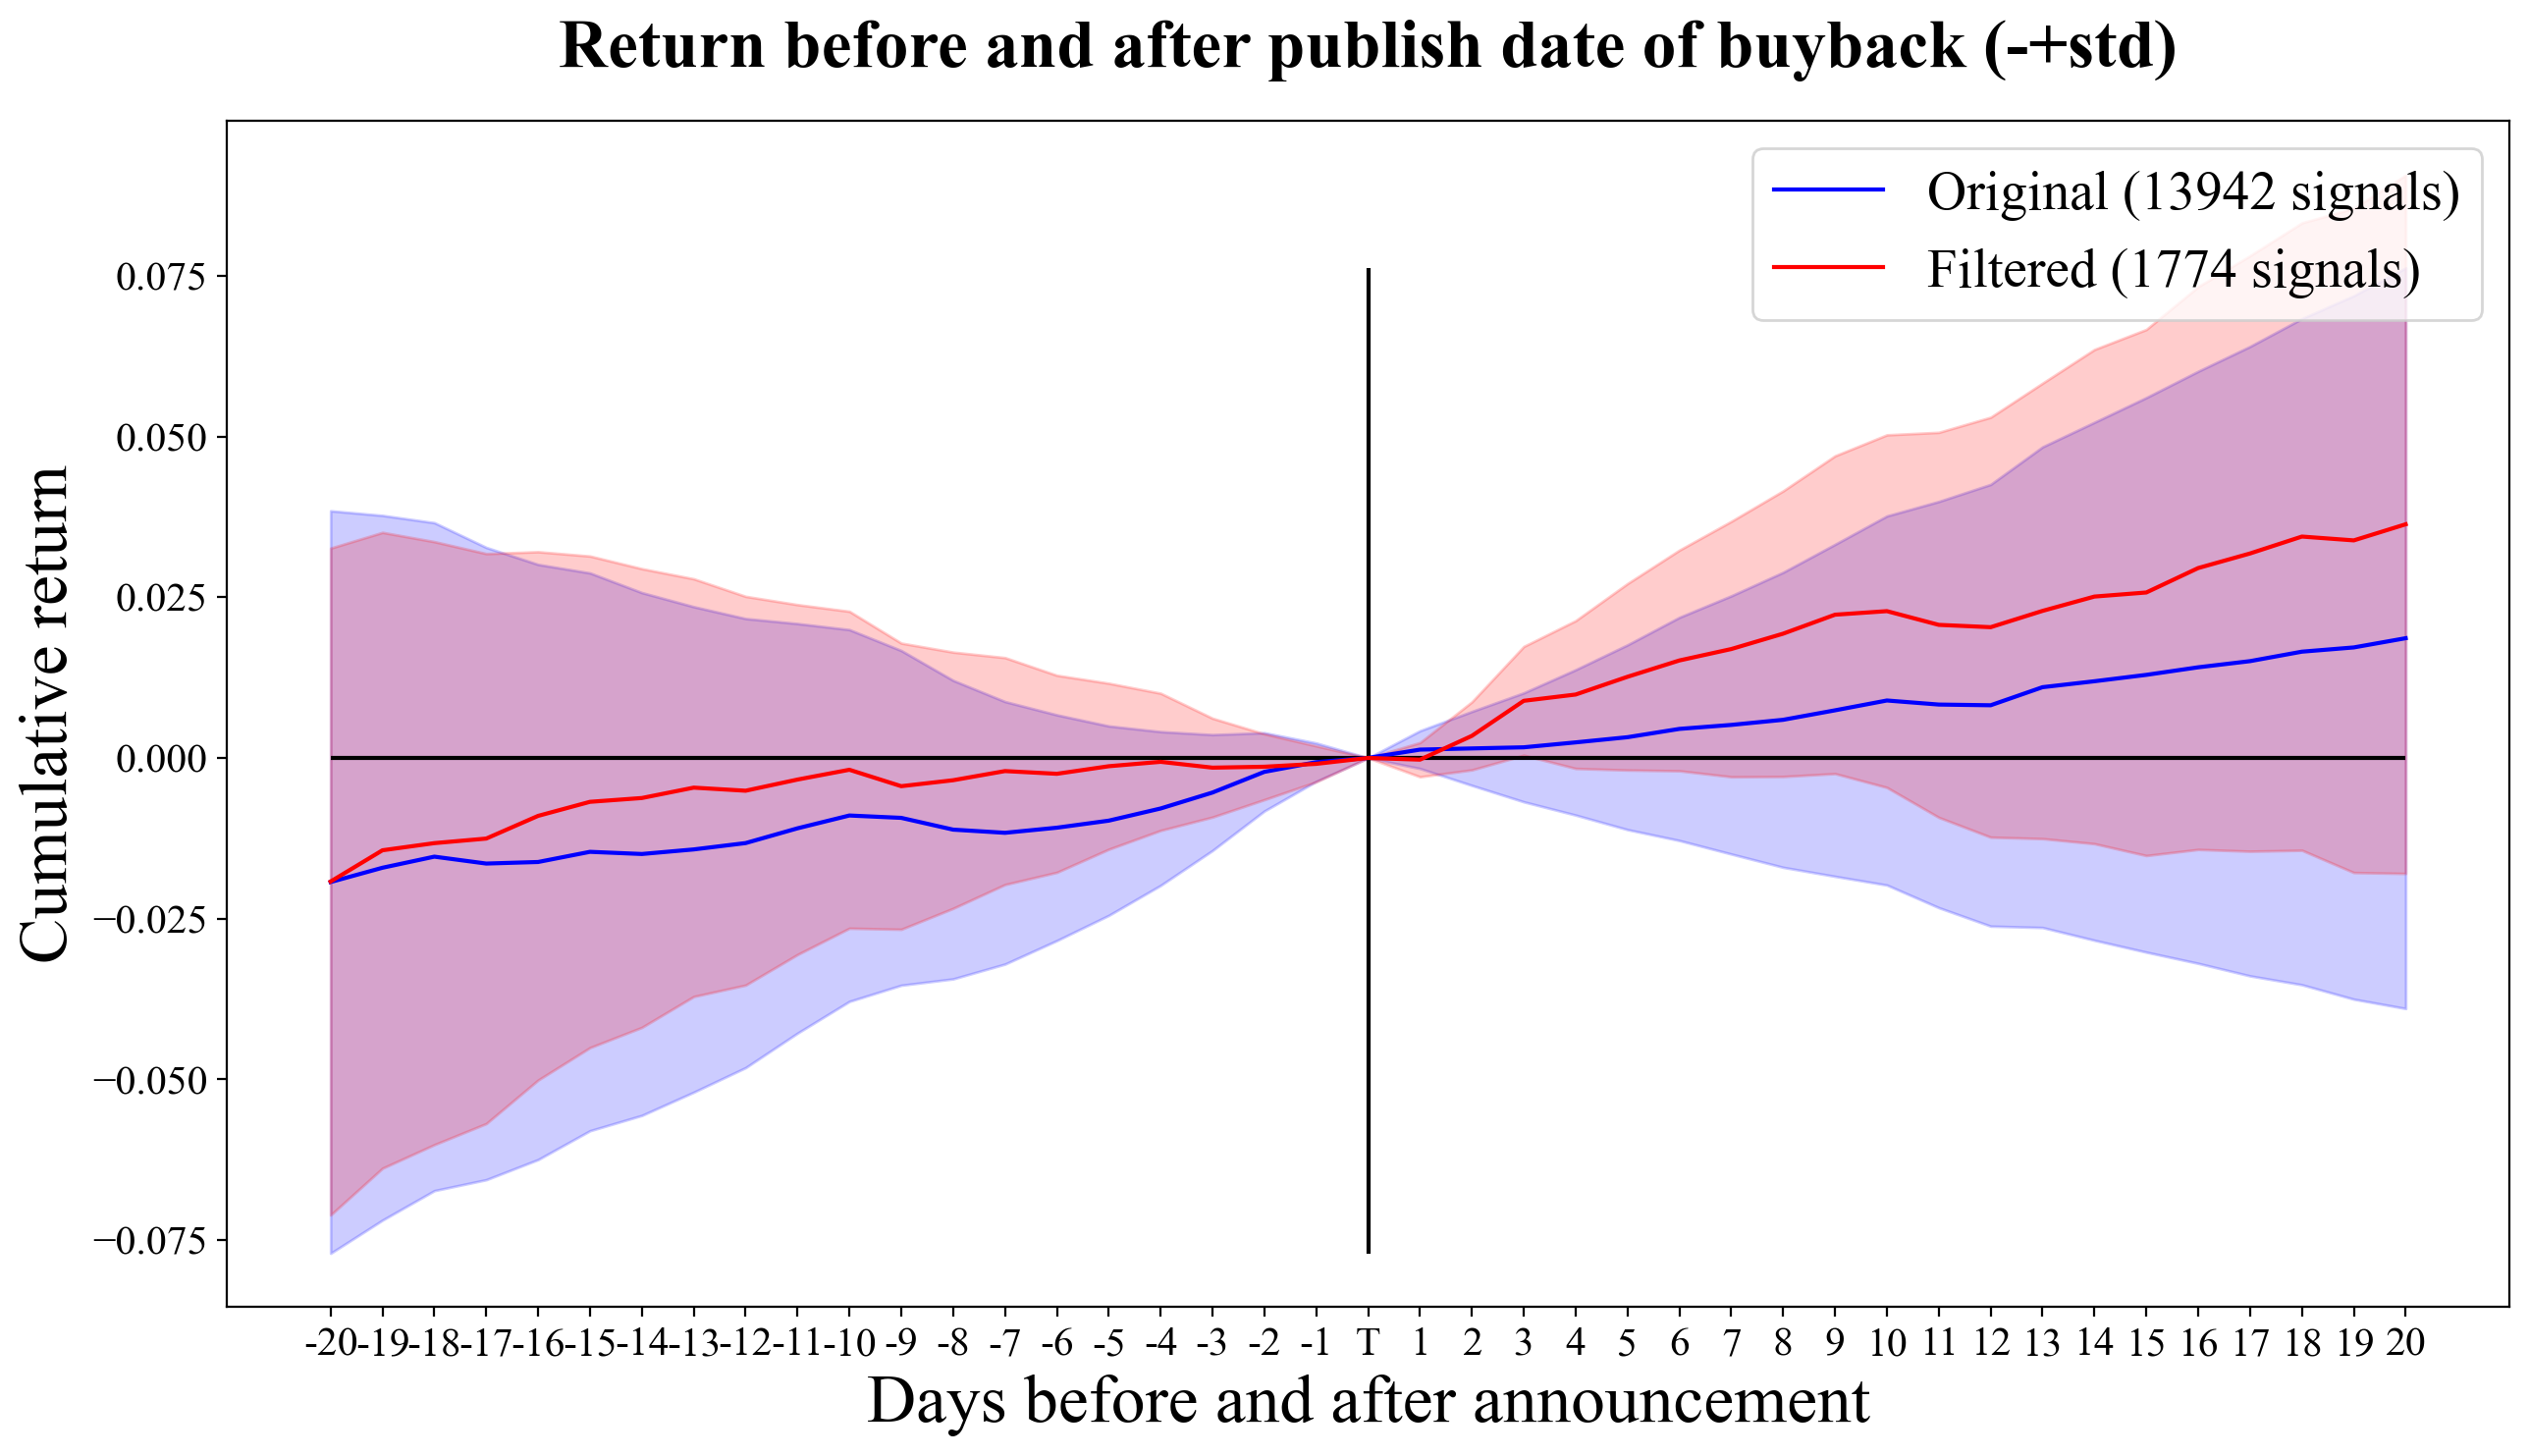

In [1278]:
a = draw_total(dfs = [buy_back_date,buy_back_part],date = 'PUBLISH_DATE',name = 'publish date of buyback')
a.savefig('/Users/jason/JC/公告数据/Figures/publish date of buyback.jpg')


目前看回购和股东股票转移都不错，可能这是公司自身自己实力雄厚的表现。定向增发、股票增值权可能并没有太好的帮助。

定向增发差别不大，因为在股票和期权两种东西上面的暴露差不多大、

回购有超额收益，但是因为股票比较少，比较震荡。回购更加偏向期权一些，但是回购本身就带有一些比较好的性质，因此收益可观。

股东股票转移具有非常高的收益，这个在股票期权方面表现也很接近。可以用这个指标筛选期权里面合适的股票。

Others非常差，主要就是股票增值权

建议主要卖股票，之后利用回购和股东股票转移进行期权部分的扩充

# 总票池统计

In [265]:
#每天每种类型的stocks，没有去重
Stk_all=[]
for i in calendar:
    Stk_daily=[]
    for j in dfs_lst:
        partial = j[j.iloc[:,0]==i]
        stks = list(partial.iloc[:,1])
        Stk_daily.append(stks)
    Stk_all.append(Stk_daily)

In [266]:
#每天每种类型的去重，并且所有加起来去重
count_all = []
count_all_dfs = []
for i in Stk_all:
    count_daily=[]
    daily_stks=[]
    for j in i:
        count_daily.append(list(set(j)))
        daily_stks += j
    count_all_dfs.append(list(set(daily_stks)))
    count_all.append(count_daily)   

In [232]:
#所有加起来计数
num_all = []
for i in count_all_dfs:
    num_all.append(len(i))

In [233]:
num_each = []
for i in count_all:
    temp=[]
    for j in i:
        temp.append(len(j))
    num_each.append(temp)
num_df = pd.DataFrame(num_each)
roll_num_df = num_df.rolling(window=20,axis=0).mean()

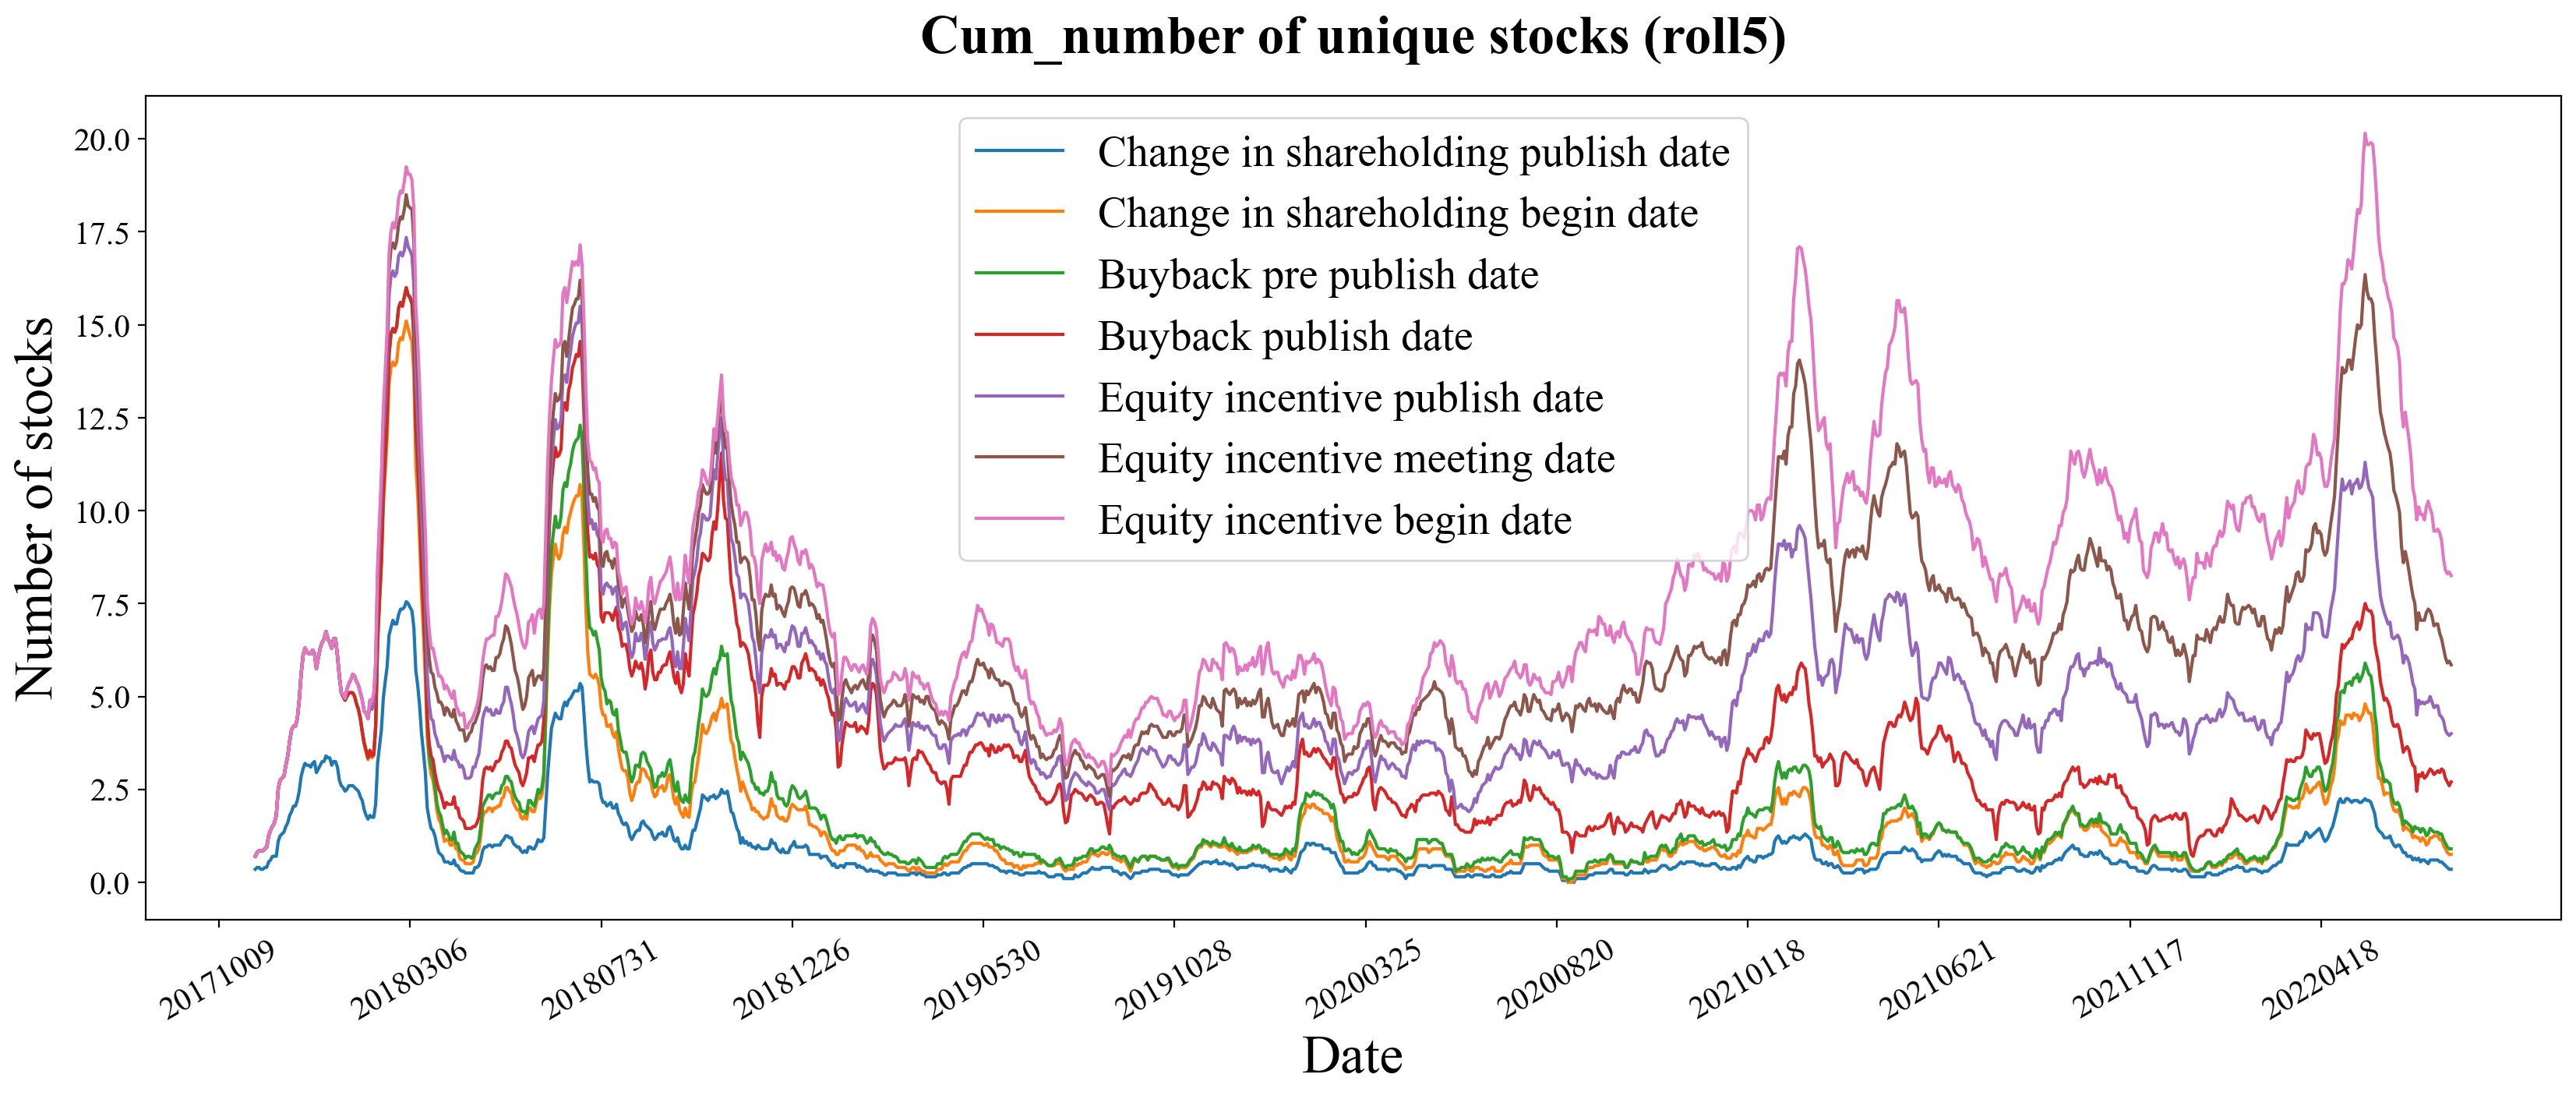

In [1264]:
cum_df = roll_num_df.cumsum(axis=1)
plt.figure(figsize=(20,7),dpi = 200)
plt.plot(cum_df)
plt.legend(['Change in shareholding publish date','Change in shareholding begin date',
            'Buyback pre publish date','Buyback publish date',
           'Equity incentive publish date','Equity incentive meeting date','Equity incentive begin date'],fontsize=20)
plt.title('Cum_number of unique stocks (roll5)',fontsize=25,pad=20,fontweight=600)
plt.xticks(np.arange(0,len(calendar),100),list(calendar)[::100],rotation=30,fontproperties='Times New Roman', size=15)
plt.yticks(fontproperties='Times New Roman', size=15)
plt.xlabel('Date', size=25)
plt.ylabel('Number of stocks', size=25)
plt.savefig('/Users/jason/JC/公告数据/Figures/cum stocks.jpg')
plt.show()
  

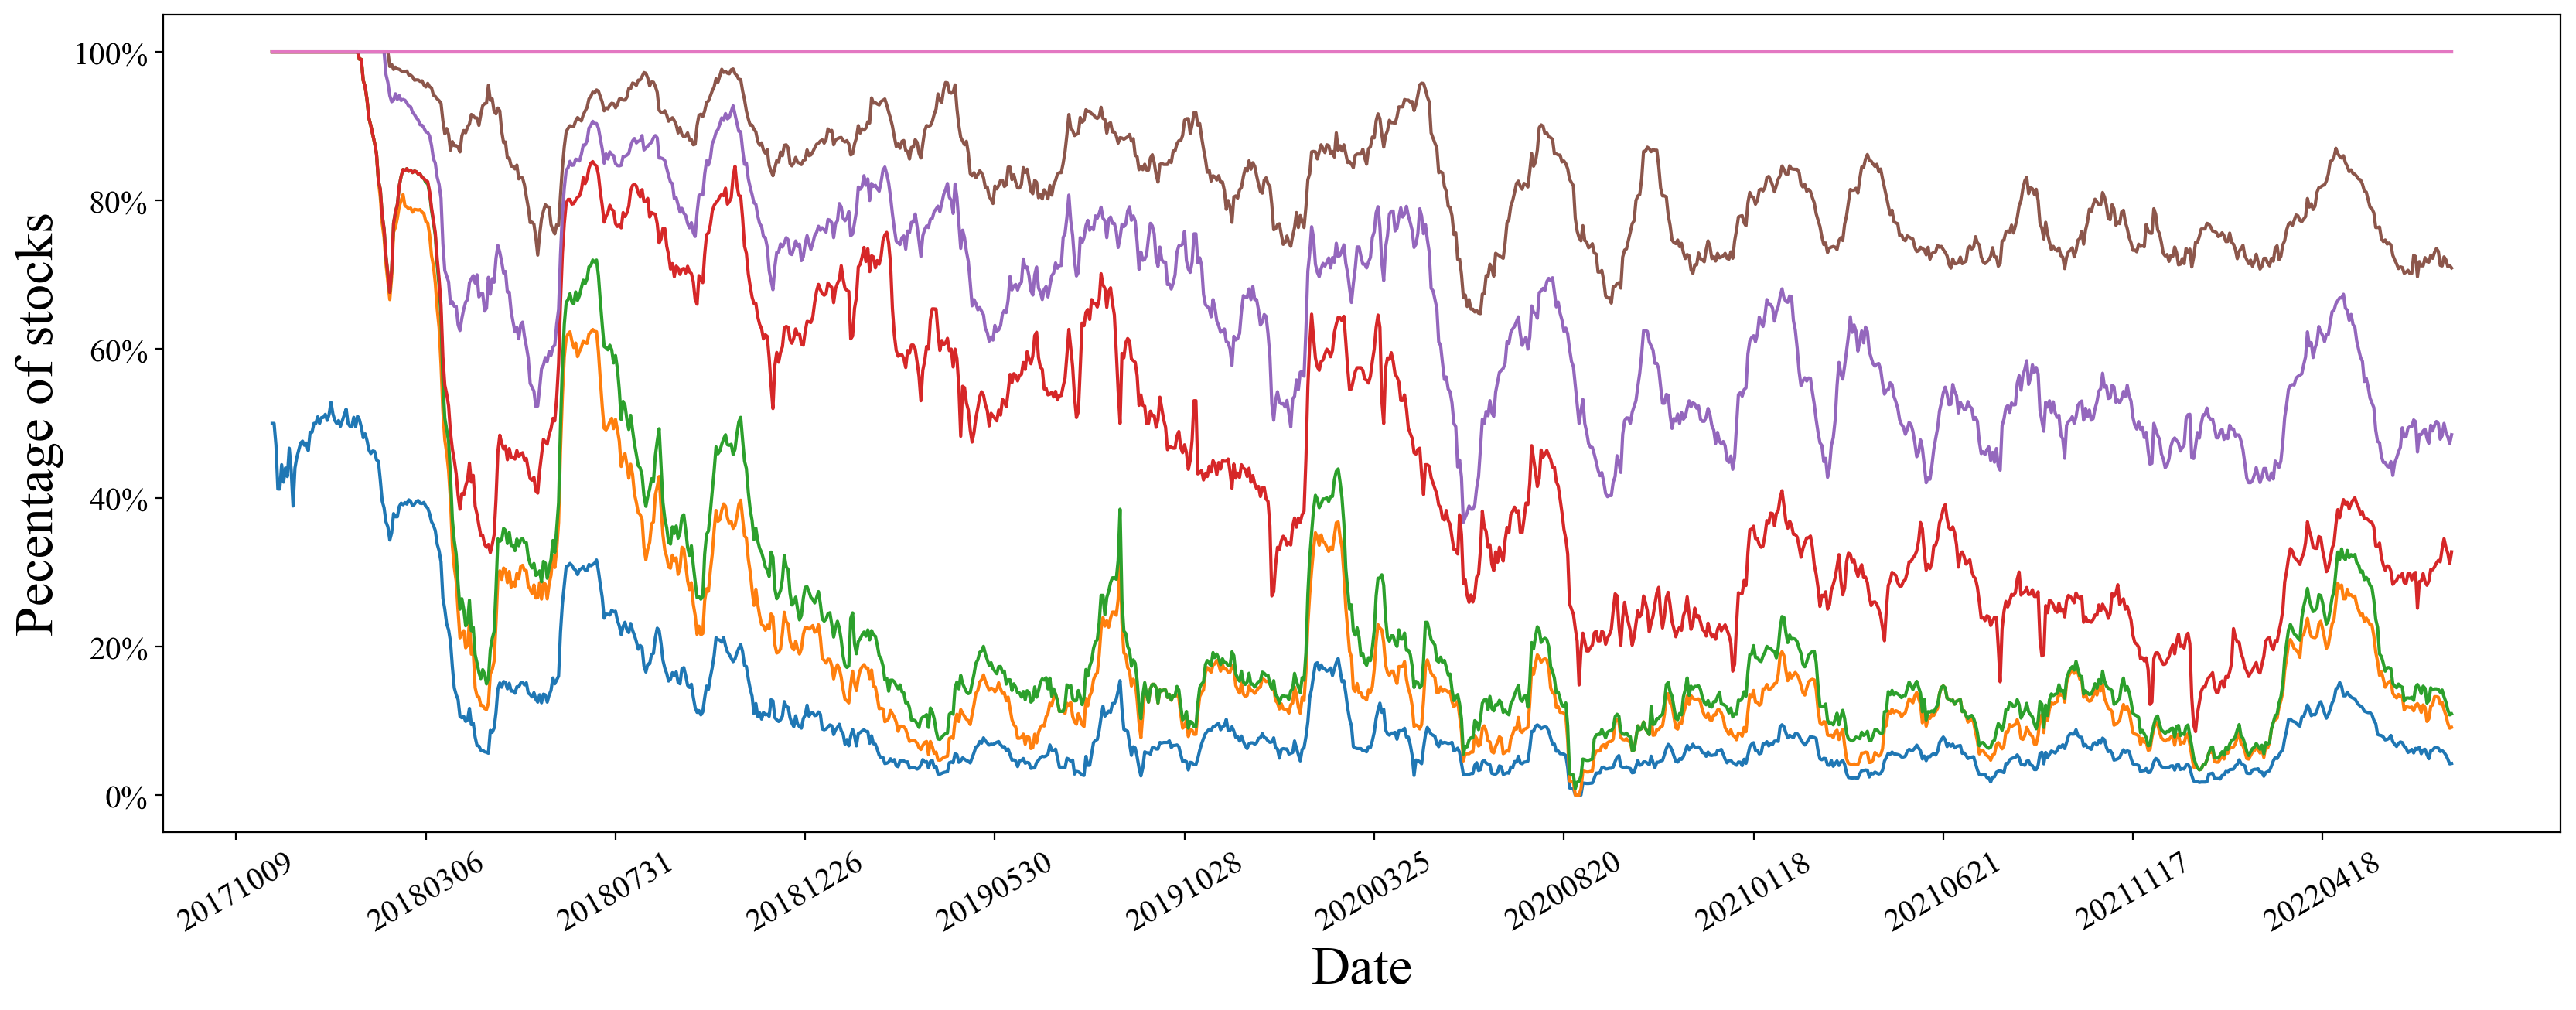

In [1281]:
cum_df_pct = roll_num_df.div(roll_num_df.sum(axis=1),axis=0).cumsum(axis=1)
plt.figure(figsize=(20,7),dpi = 200)
plt.plot(cum_df_pct)
#plt.title('Cum_percentage of unique stocks (roll5)',fontsize=25,pad=20,fontweight=600)
plt.xticks(np.arange(0,len(calendar),100),list(calendar)[::100],rotation=30,fontproperties='Times New Roman', size=15)
plt.yticks(np.arange(0,1.2,0.2),[str(int(i))+'%' for i in np.arange(0,1.2,0.2)*100],fontproperties='Times New Roman', size=15)
plt.xlabel('Date', size=25)
plt.ylabel('Pecentage of stocks', size=25)
plt.savefig('/Users/jason/JC/公告数据/Figures/Per stocks.jpg')
plt.show()
  

<ipython-input-1270-a2abd103581d>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(labels=np.arange(-5,40,5),fontsize=15)


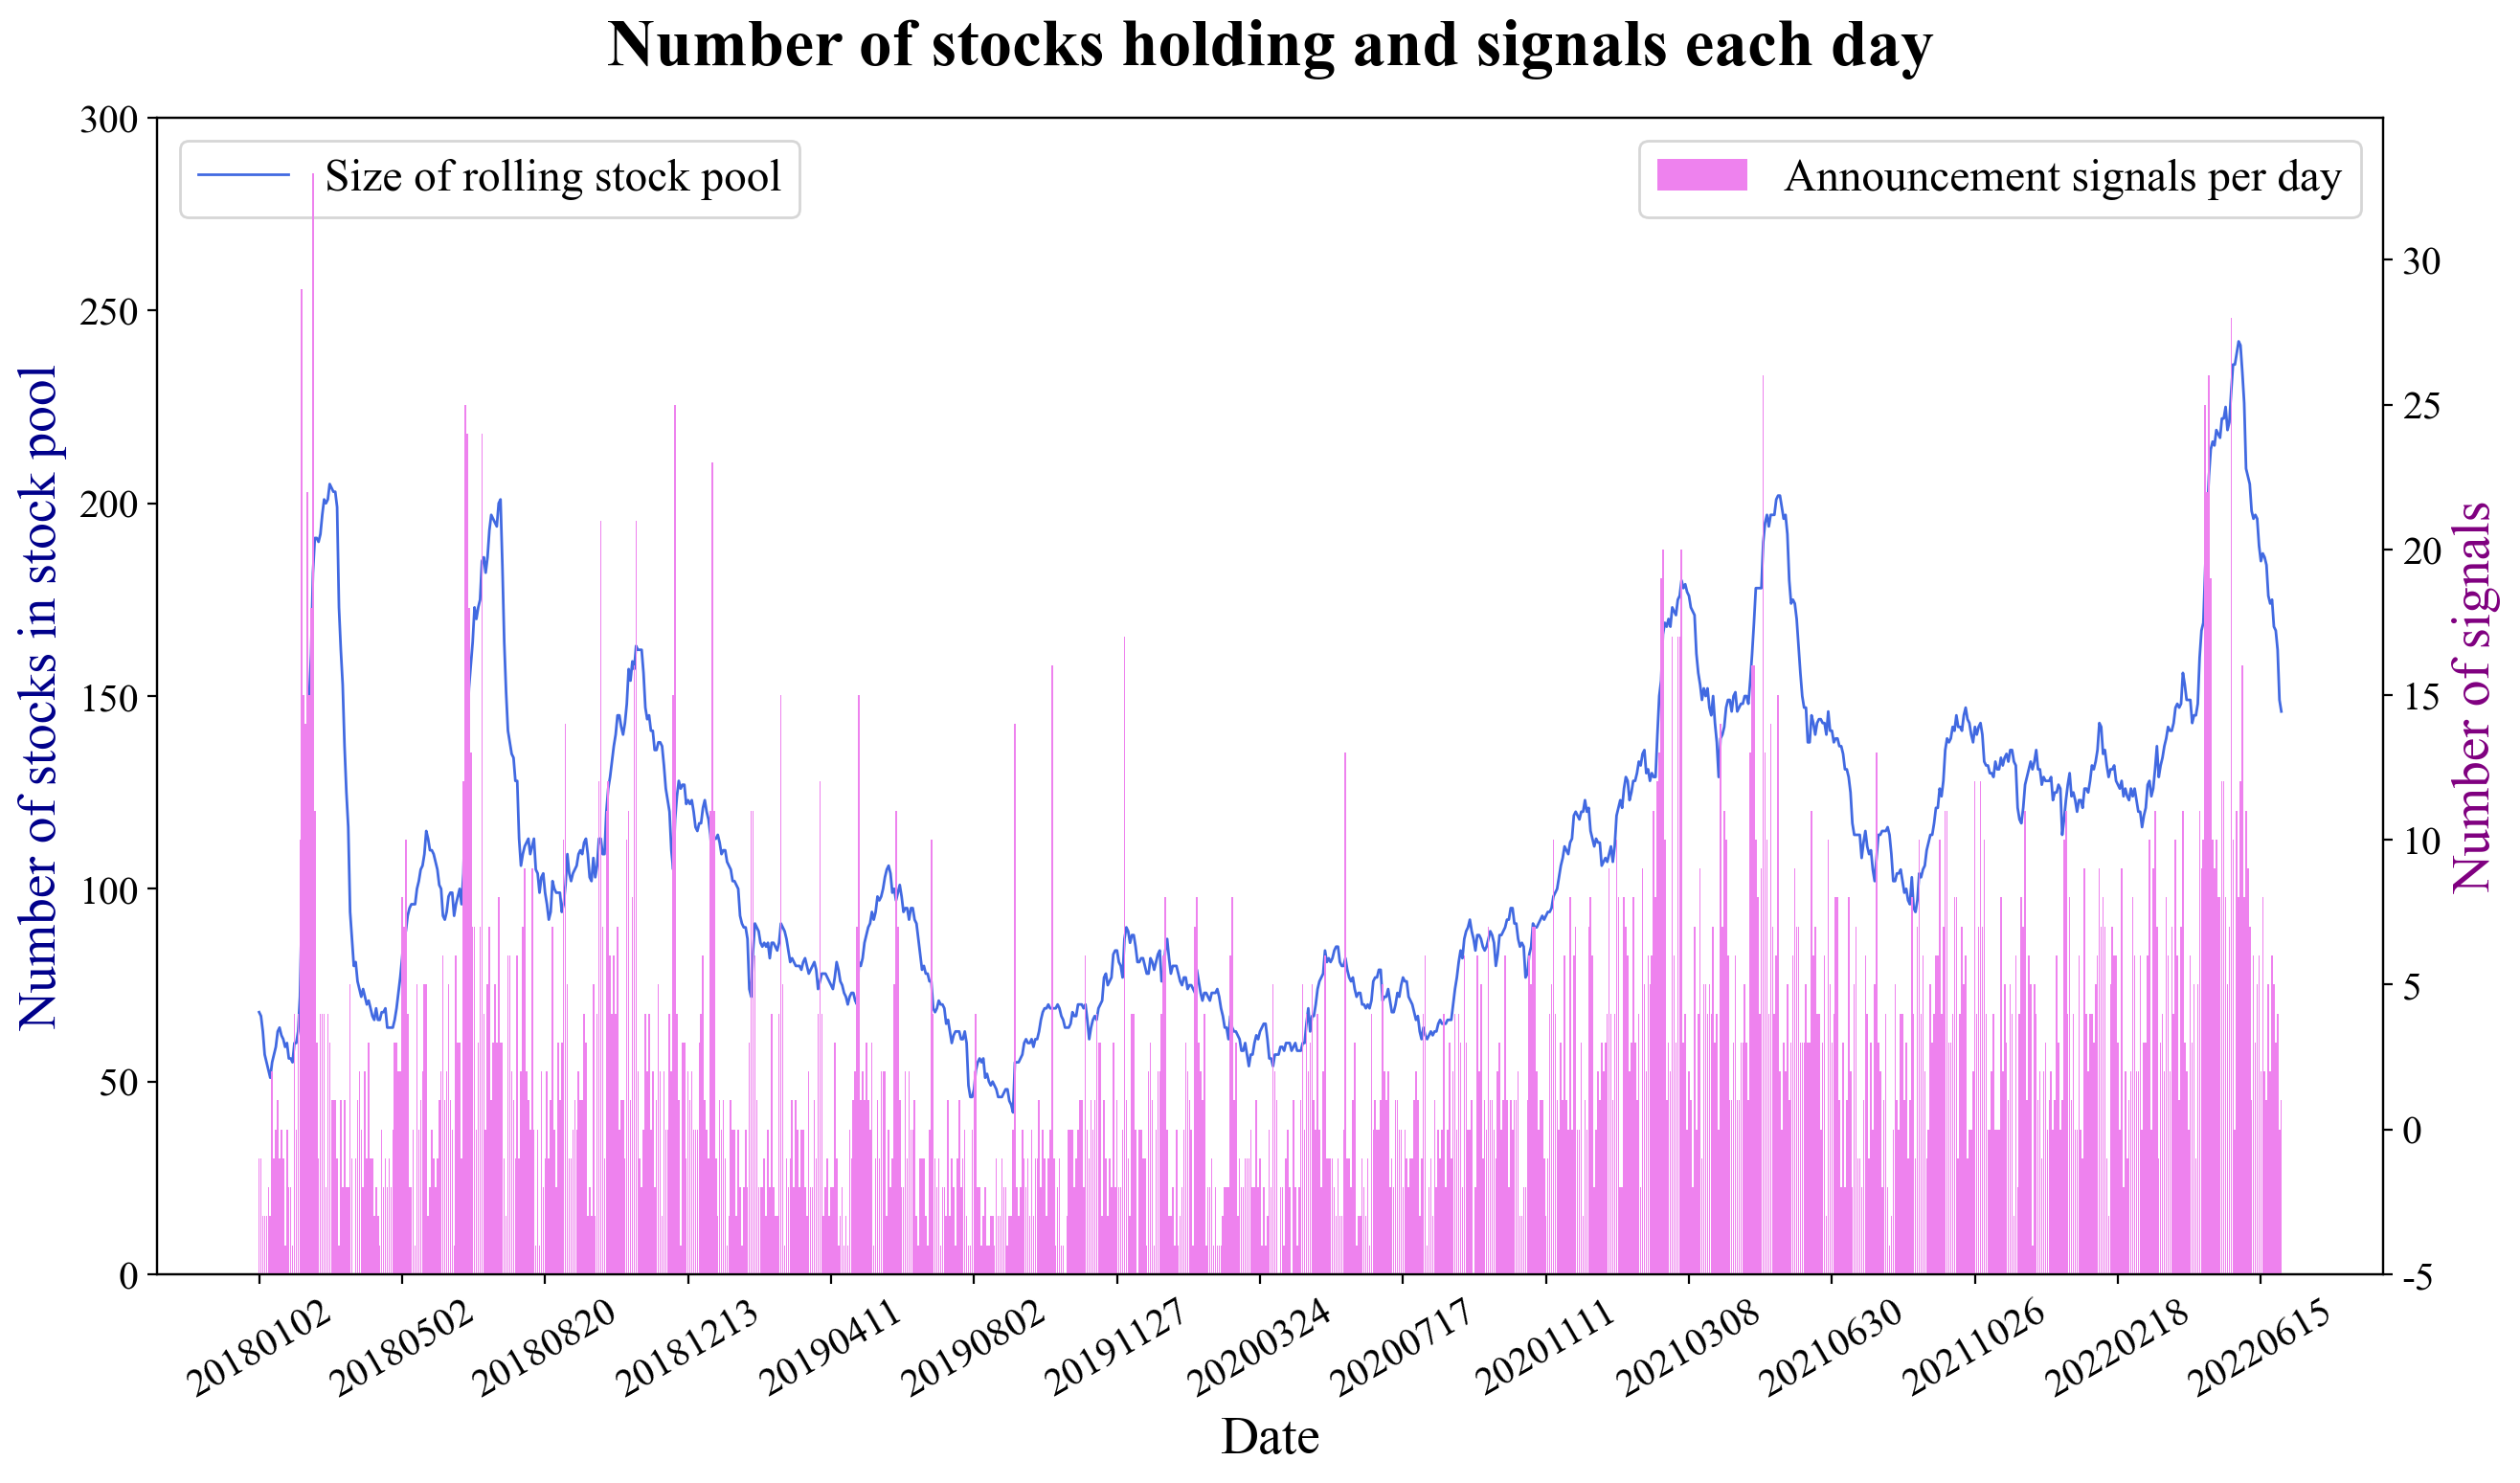

In [1270]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 8),dpi=200)
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
clrs1=['royalblue','violet']

ax = list(range(0,len(rtn_raw_df[0].index)))
ax1.plot(rtn_raw_df.iloc[:,0], markersize=0.5, color=clrs1[0], linewidth=1, linestyle='-')
#ax1.plot(list(rtn_raw_tovr_df.iloc[:,i].cumsum()), markersize=0.5, color=clrs2[i], linewidth=1, linestyle='--')

d = 14
ax1.set_xticks(rtn_raw_df.index[::int(len(list(rtn_raw_df.index))/d)])
ax1.set_yticks(np.arange(0,350,50))
ax1.set_yticklabels(labels=np.arange(0,350,50),fontsize=15)
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Number of stocks in stock pool',fontsize=20,color = 'darkblue')
ax1.set_xticklabels(labels=rtn_raw_df.index[::int(len(list(rtn_raw_df.index))/d)],rotation=30,fontsize=15)

ax2 = ax1.twinx()
ax2.bar(rtn_raw_df.iloc[:,1].index,rtn_raw_df.iloc[:,1], color=clrs1[1], linewidth=1, linestyle='-')
ax2.set_xticks(rtn_raw_df.index[::int(len(list(rtn_raw_df.index))/d)])
ax2.set_ylabel('Number of signals',fontsize=20,color = 'purple')
ax2.set_yticklabels(labels=np.arange(-5,40,5),fontsize=15)
ax2.set_xticklabels(labels=rtn_raw_df.index[::int(len(list(rtn_raw_df.index))/d)],rotation=30,fontsize=15)

ax1.legend(['Size of rolling stock pool'], loc='upper left',ncol=2,fontsize=17)
ax2.legend(['Announcement signals per day'], loc='upper right',ncol=2,fontsize=17)
#plt.title(title,fontsize=20,pad=18,fontproperties='Times New Roman',fontweight=600)
plt.xticks(fontproperties='Times New Roman', size=20)
plt.title('Number of stocks holding and signals each day',fontsize=25,pad=20,fontweight=600)

plt.savefig('/Users/jason/JC/公告数据/Figures/Stock_pool_num.jpg')

plt.show()

# 存储数据：Signal

In [1415]:
save_variable(signal_df,pickle_path+'signal_df')

'/Users/jason/JC/公告数据/signal_df'

In [312]:
save_variable(signal_df,path+'signal_df')

'/Users/jason/Desktop/公告类数据/signal_df'

In [314]:
save_variable(ind_ret_part,path + 'index_return')

'/Users/jason/Desktop/公告类数据/index_return'